In [17]:
import pyvisa
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA
# from nanodrivers.visa_drivers.signal_analizar import Anri

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize

#file_store
import os

#time
import time
from datetime import datetime, timedelta


from ctypes import *
%matplotlib inline

In [18]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,0.4.204



In [19]:
dc = DC()
dc.idn()

Connection exist: HEWLETT-PACKARD,33120A,0,7.0-5.0-1.0



In [21]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



In [16]:
# sa = Anri()
# sa.idn()

Connection exist: ANRITSU,MS2830A,6200847105,4.09.01



# Set all devices to default values and define functions

In [44]:
anapico.set_off(1)
dc.set_volt(0)

def get_ref_gain():
    anapico.set_off(1)
#     dc.set_volt(0)
    time.sleep(0.5)
    mag, pha = vna.get_data()
    reference_mag_level = np.mean(mag)
    return reference_mag_level

def get_FP_sweep(dc_curr, freqs, pows, m_ref): 
    dc.set_volt(dc_curr)
    pow_steps = np.size(pows)
    freq_steps = np.size(freqs)
    
    power = np.linspace(pows[0], pows[-1], pow_steps)
    frequency = np.linspace(freqs[0], freqs[-1], freq_steps)
    anapico.set_on(1)
    time.sleep(0.5)
    
    gain = np.empty((pow_steps,freq_steps))
    for i in range(pow_steps):
        for j in range(freq_steps):
            anapico.set_power(1, pows[i])
            anapico.set_freq(1, freqs[j]*1e9)
            mag, pha = vna.get_data()
            gain[i,j] = np.mean(mag)-m_ref
    
    return gain

In [24]:
(0.1*201*101+0.5)*101/3600

56.969611111111114

In [ ]:
# Boundaries

start = datetime.now() 

folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise\GainSweep'
file = r'Sweep_'+ start.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = folder +'\\' + file

freq_pump_max = 13 #GHz
freq_pump_min = 9 #GHz
freq_pump_steps = 201
freqs = np.linspace(freq_pump_min, freq_pump_max, freq_pump_steps) 

power_pump_max = 20 #dBm
power_pump_min = -20 #dBm
power_pump_steps = 101
pows = np.linspace(power_pump_min, power_pump_max, power_pump_steps)

DC_max = 3
DC_min = 1
DC_steps = 101
DC = np.linspace(DC_min, DC_max, DC_steps)

dc.set_volt(DC[0])
time.sleep(50)

Gain = np.empty((len(DC),len(pows),len(freqs)))
mag_ref = np.empty((len(DC)))

state=dict()
state['freqs'] = freqs
state['pows'] = pows
state['DC'] = DC
state['Gain'] = Gain

for i in range(len(DC)): 
    start_time = datetime.now()
    fig, ax = plt.subplots(figsize=(25,13))
    
    mag_ref[i] = get_ref_gain()
    gain = get_FP_sweep(DC[i], freqs, pows, mag_ref[i]) 
    Gain[i,:,:] = gain
    state['mag_ref'] = mag_ref
    state['Gain'] = Gain
    
    c = ax.pcolor(freqs, pows, gain, cmap='viridis')
    fig.colorbar(c, ax=ax)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
     
    savemat(file_name, state)
    
dc.set_volt(0)
time.sleep(60)

savemat(file_name, state)

Duration: 1:53:10.047736
Duration: 1:53:06.992493
Duration: 1:53:16.467463
Duration: 1:53:17.694053
Duration: 1:53:15.024225
Duration: 1:52:38.362085
Duration: 1:53:46.807298
Duration: 1:53:12.640744
Duration: 1:53:13.328648
Duration: 1:53:15.059814


In [41]:
start = datetime.now() 
state=dict()
state['freqs'] = freqs
state['pows'] = pows
state['DC'] = DC
state['Gain'] = Gain
folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise\GainSweep'
file = r'Sweep_'+ start.strftime(r'%Y-%m-%d-%H-%M-%S') + '.mat'
file_name = folder +'\\' + file
display(file_name)

'C:\\Users\\Demag\\PycharmProjects\\ColdMeasurements\\DeMag\\DATA\\TWPA_noise\\GainSweep\\Sweep_2024-02-09-18-32-53.mat'

Duration: 0:01:51.647533


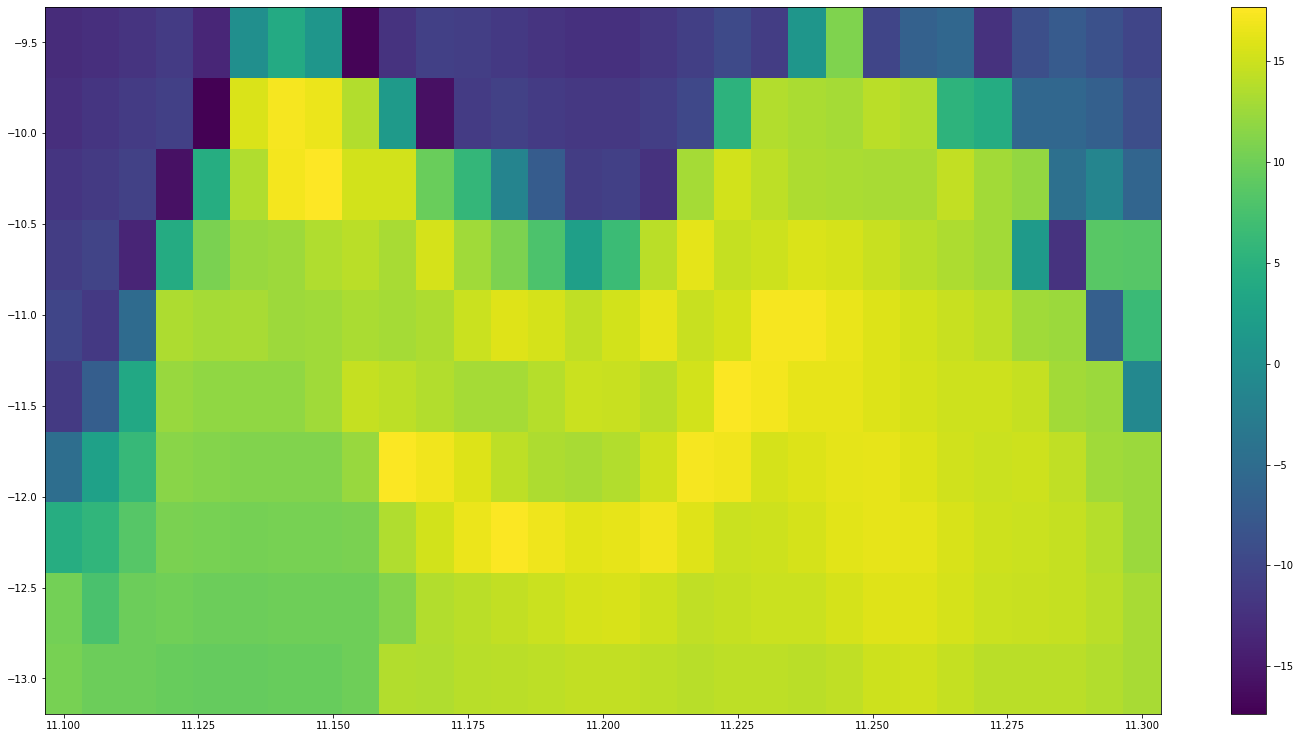

In [129]:
%matplotlib inline
low_freq = 11.1
high_freq = 11.3
low_power = -13
high_power = -9.5

start_time = datetime.now()
fig, ax = plt.subplots(figsize=(25,13))
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 30, pow_steps = 10) 
c = ax.pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [166]:
# find 4 largest candidates

indices = gain.ravel().argsort()
amax = gain.ravel()[indices[-4:]]
p = np.array([])
f = np.array([])
for i in range(4):
    amax_local = amax[i]
    r1, c1 = np.where(gain == amax_local)
    p = np.append(p, power[r1[0]])
    f = np.append(f, freq[c1[0]])
    print('pow[{}]={}, freq[{}]={}: {}'.format(r1[0], power[r1[0]], c1[0], freq[c1[0]], amax_local) )

pow[2]=-12.222222222222221, freq[12]=11.182758620689656: 17.432368961900217
pow[3]=-11.833333333333334, freq[9]=11.162068965517241: 17.44700624953927
pow[4]=-11.444444444444445, freq[18]=11.224137931034482: 17.4921023362091
pow[7]=-10.277777777777779, freq[7]=11.148275862068965: 17.669440867952346


In [168]:
%matplotlib qt

fig, ax = plt.subplots(2, 2,figsize=(25,13))

offset_f = 0.05
offset_p = 0.3

start_time = datetime.now()
low_freq = f[0]-offset_f
high_freq = f[0]+offset_f
low_power = p[0]-offset_p
high_power = p[0]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[0,0].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[0,0])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
low_freq = f[1]-offset_f
high_freq = f[1]+offset_f
low_power = p[1]-offset_p
high_power = p[1]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[0,1].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[0,1])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
low_freq = f[2]-offset_f
high_freq = f[2]+offset_f
low_power = p[2]-offset_p
high_power = p[2]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[1,0].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[1,0])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
low_freq = f[3]-offset_f
high_freq = f[3]+offset_f
low_power = p[3]-offset_p
high_power = p[3]+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.45, freq_steps = 20, pow_steps = 20) 
c = ax[1,1].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax=ax[1,1])
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:02:27.182780
Duration: 0:02:27.111038
Duration: 0:02:27.215555
Duration: 0:02:27.349955


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25,13))

cent_freq = 11.182
cent_pow = -11.54

offset_f = 0.01
offset_p = 0.1
start_time = datetime.now()
low_freq = cent_freq-offset_f
high_freq = cent_freq+offset_f
low_power = cent_pow-offset_p
high_power = cent_pow+offset_p
power, freq, gain = get_FP_sweep(dc_curr=2.38, freq_steps = 5, pow_steps = 5) 
c = ax[0].pcolor(freq, power, gain, cmap='viridis')
fig.colorbar(c, ax= ax[0])


cent_freq = cent_freq/2*1e9
span = 45e6
nop = 1001
min_freq = cent_freq-span/2
max_freq = cent_freq+span/2
freq = np.linspace(min_freq, max_freq, nop)
band=100

sa.set_cent_freq(cent_freq)
sa.set_span(span)
sa.set_band_Hz(band)
sa.set_nop(nop)

# Modes
mode1 = (cent_freq+2e6)
mode1_pow = 0
anapico.set_freq(2, mode1)
anapico.set_power(2, mode1_pow)
anapico.on(2)

mode2 = (cent_freq+3e6)
mode2_pow = 0
anapico.set_freq(4, mode2)
anapico.set_power(4, mode2_pow)
anapico.on(4)

data = sa.get_data()
ax[1].plot(freq, data)
ax[1].vlines(mode1, min(data), max(data), '#610023', linewidth=1.0, label = 'Mode 1')
ax[1].vlines(mode2, min(data), max(data), '#be013c', linewidth=1.0,  label = 'Mode 2')
ax[1].legend(loc = 1, prop={'size': 11})

anapico.off(2)
anapico.off(4)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [ ]:
anapico.off(2)
anapico.off(4)

In [11]:
freq_best = 11.178884
pow_best = -11.72
dc_best = 2.42

# Spectrum

Duration: 0:22:46.639008


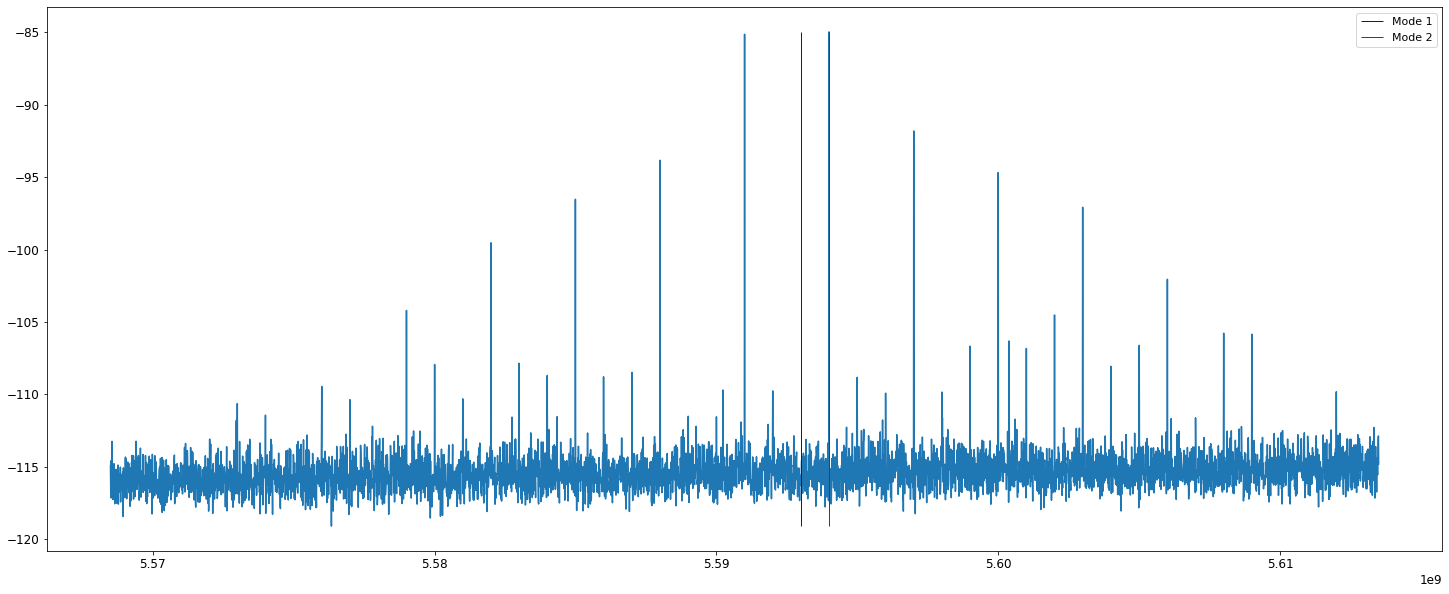

In [148]:
cent_freq = 11.182

cent_freq = cent_freq/2*1e9
span = 45e6
nop = 5001
min_freq = cent_freq-span/2
max_freq = cent_freq+span/2
freq = np.linspace(min_freq, max_freq, nop)
band=100

sa.set_cent_freq(cent_freq)
sa.set_span(span)
sa.set_band_Hz(band)
sa.set_nop(nop)

# Modes
mode1 = (cent_freq+2e6)
mode1_pow = 0
anapico.set_freq(2, mode1)
anapico.set_power(2, mode1_pow)
anapico.on(2)

mode2 = (cent_freq+3e6)
mode2_pow = 0
anapico.set_freq(4, mode2)
anapico.set_power(4, mode2_pow)
anapico.on(4)

data = sa.get_data()
fig, ax = plt.subplots(figsize=(25,10))
ax.plot(freq, data)
ax.vlines(mode1, min(data), max(data), '#610023', linewidth=1.0, label = 'Mode 1')
ax.vlines(mode2, min(data), max(data), '#be013c', linewidth=1.0,  label = 'Mode 2')
ax.legend(loc = 1, prop={'size': 11})

anapico.off(2)
anapico.off(4)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

# Intermodulation distortion

Start: 13-22-18
est runtime 0:52:00
New voltage 2.35 set at 13:22.18. Finnish: 14:14.18
New voltage 2.358 set at 13:24.50. Finnish: 14:14.50
New voltage 2.366 set at 13:27.21. Finnish: 14:15.21
New voltage 2.374 set at 13:29.54. Finnish: 14:15.54
New voltage 2.382 set at 13:32.26. Finnish: 14:16.26
New voltage 2.39 set at 13:34.57. Finnish: 14:16.57
New voltage 2.398 set at 13:37.28. Finnish: 14:17.28
New voltage 2.406 set at 13:39.59. Finnish: 14:17.59
New voltage 2.414 set at 13:42.30. Finnish: 14:18.30
New voltage 2.422 set at 13:45.02. Finnish: 14:19.02
New voltage 2.43 set at 13:47.33. Finnish: 14:19.33
New voltage 2.438 set at 13:50.04. Finnish: 14:20.04
New voltage 2.446 set at 13:52.35. Finnish: 14:20.35
New voltage 2.4539999999999997 set at 13:55.06. Finnish: 14:21.06
New voltage 2.4619999999999997 set at 13:57.37. Finnish: 14:21.37
New voltage 2.4699999999999998 set at 14:00.10. Finnish: 14:22.10
New voltage 2.4779999999999998 set at 14:02.41. Finnish: 14:22.41
New voltage 2.

C:\Users\Demag\AppData\Local\Temp\ipykernel_27144\4050297078.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,figsize=(25,10))


New voltage 2.518 set at 14:15.16. Finnish: 14:25.16
New voltage 2.526 set at 14:17.48. Finnish: 14:25.48
New voltage 2.534 set at 14:20.19. Finnish: 14:26.19
New voltage 2.542 set at 14:22.50. Finnish: 14:26.50
New voltage 2.55 set at 14:25.21. Finnish: 14:27.21


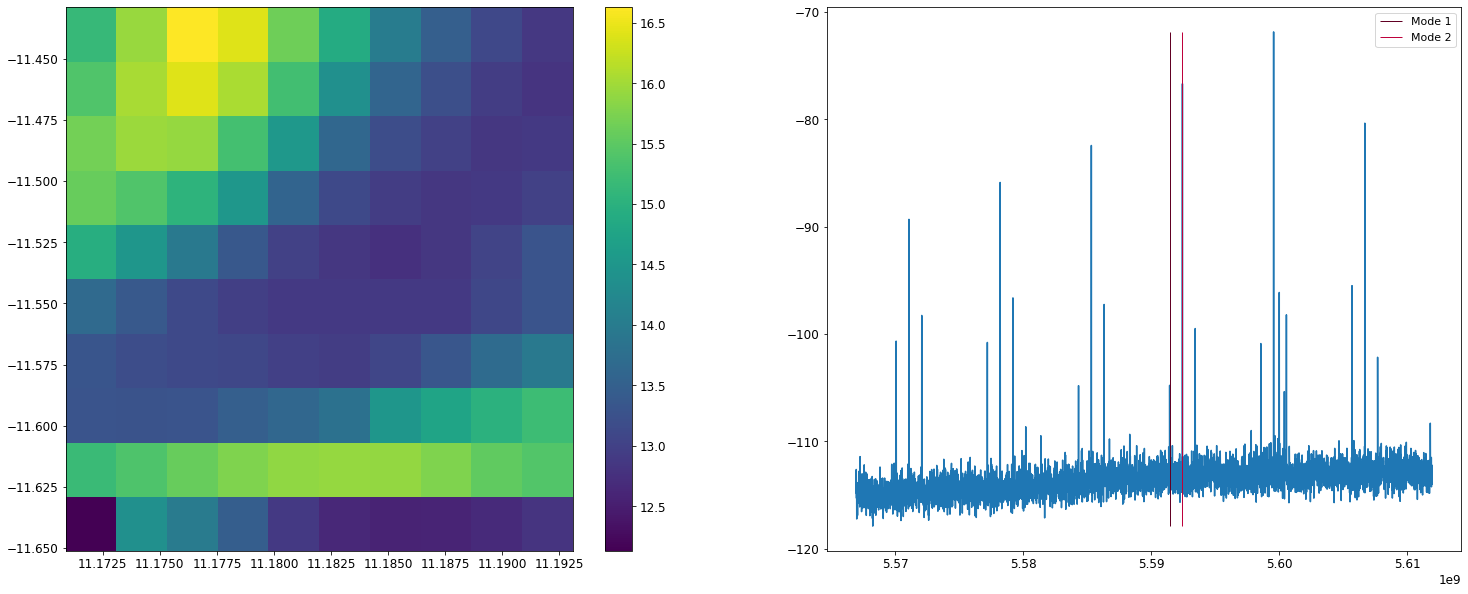

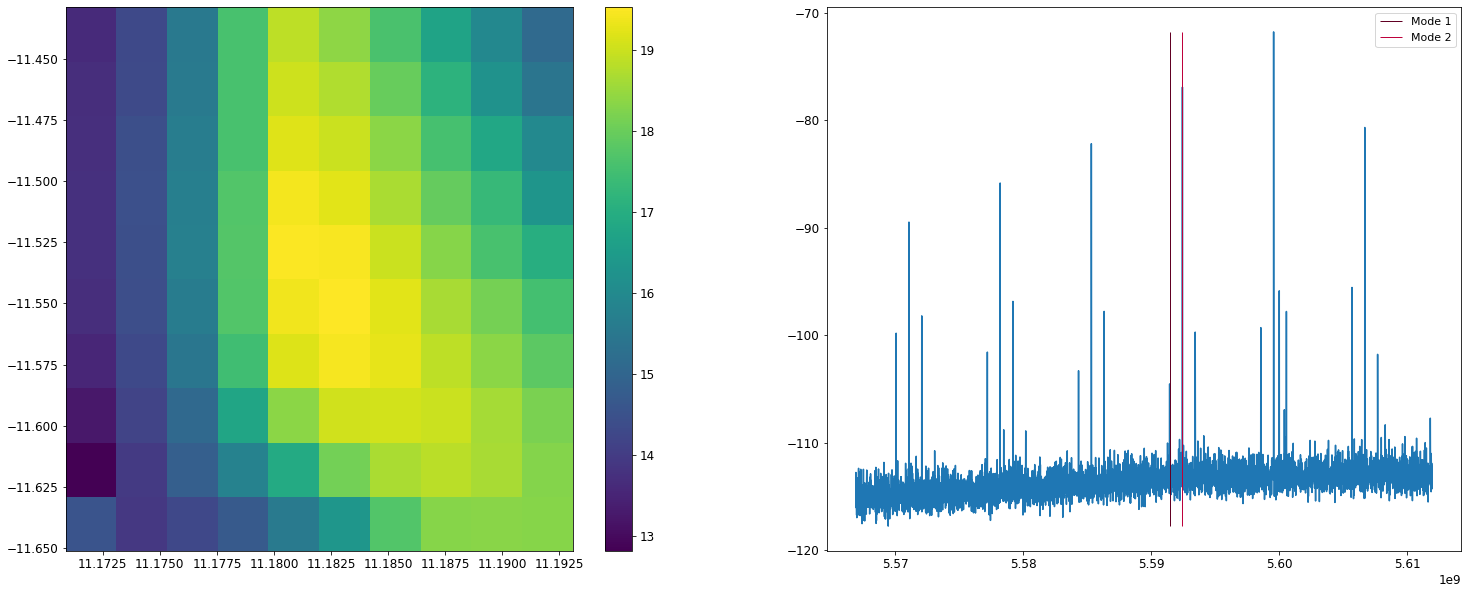

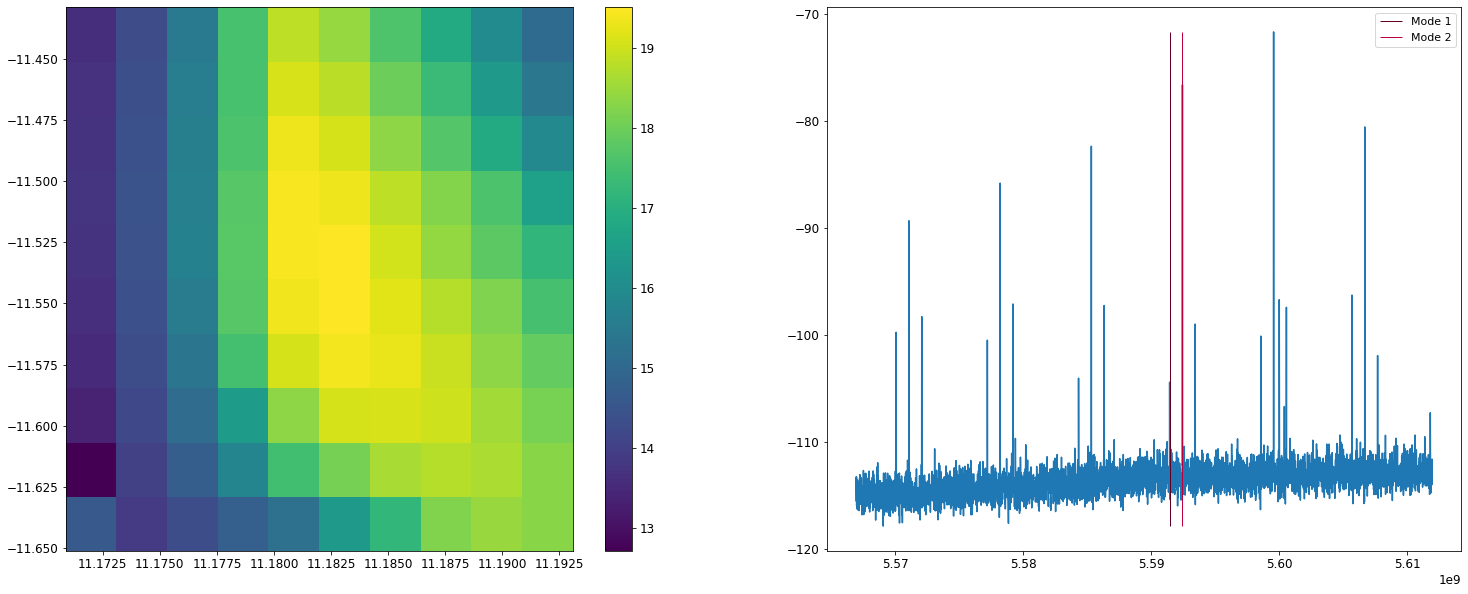

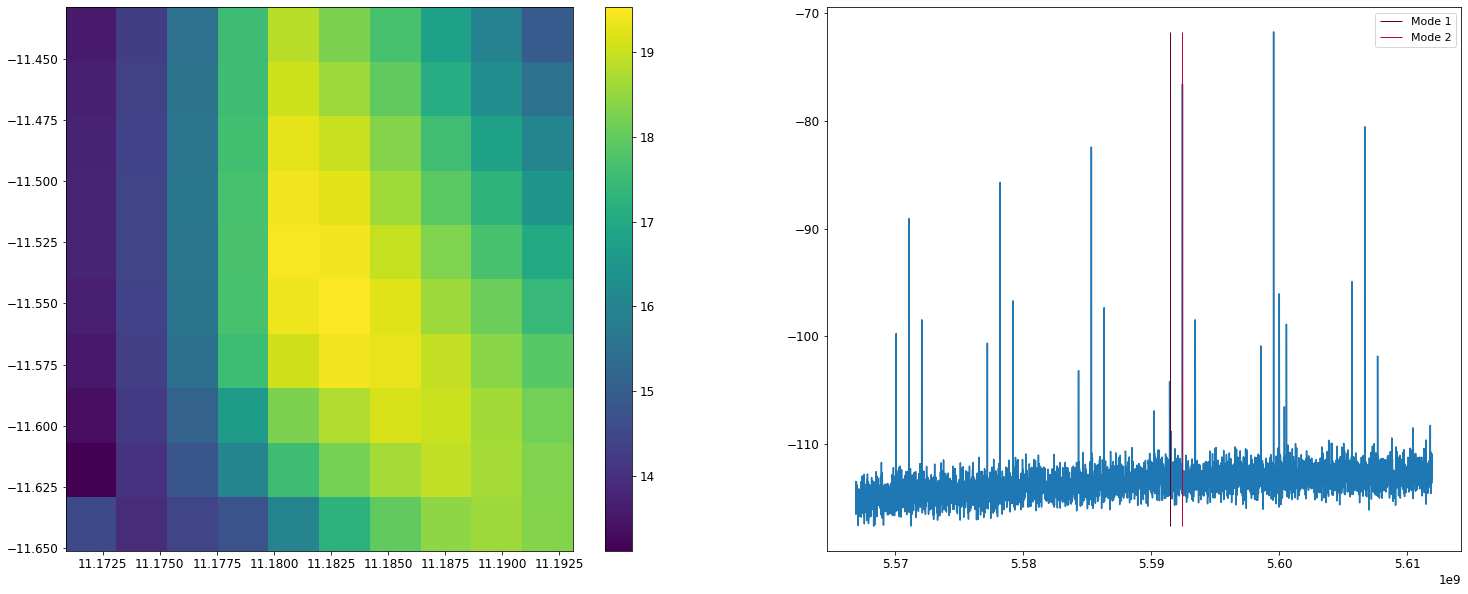

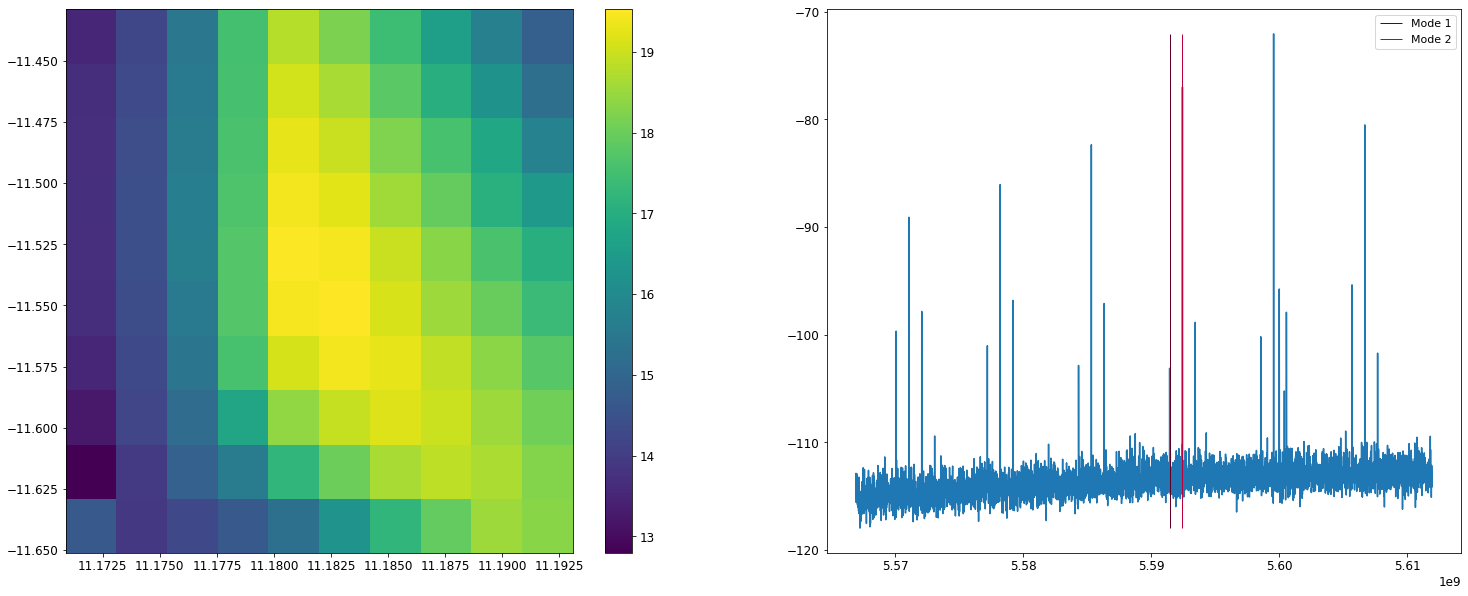

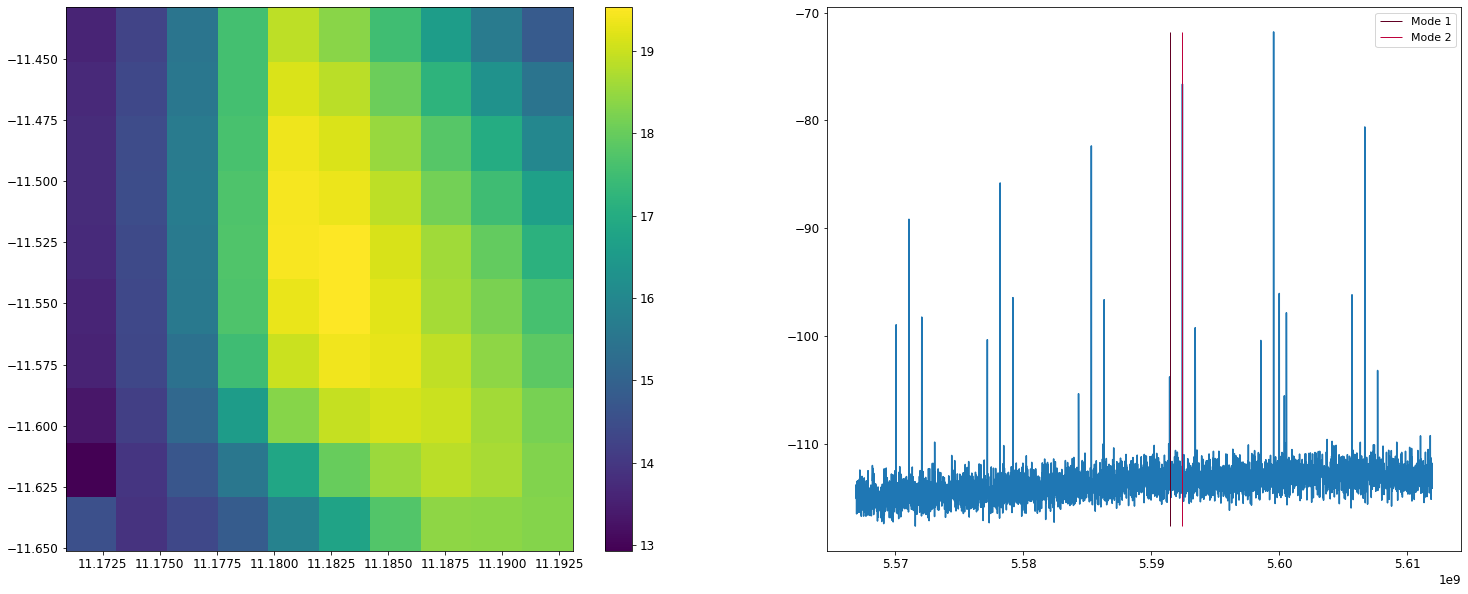

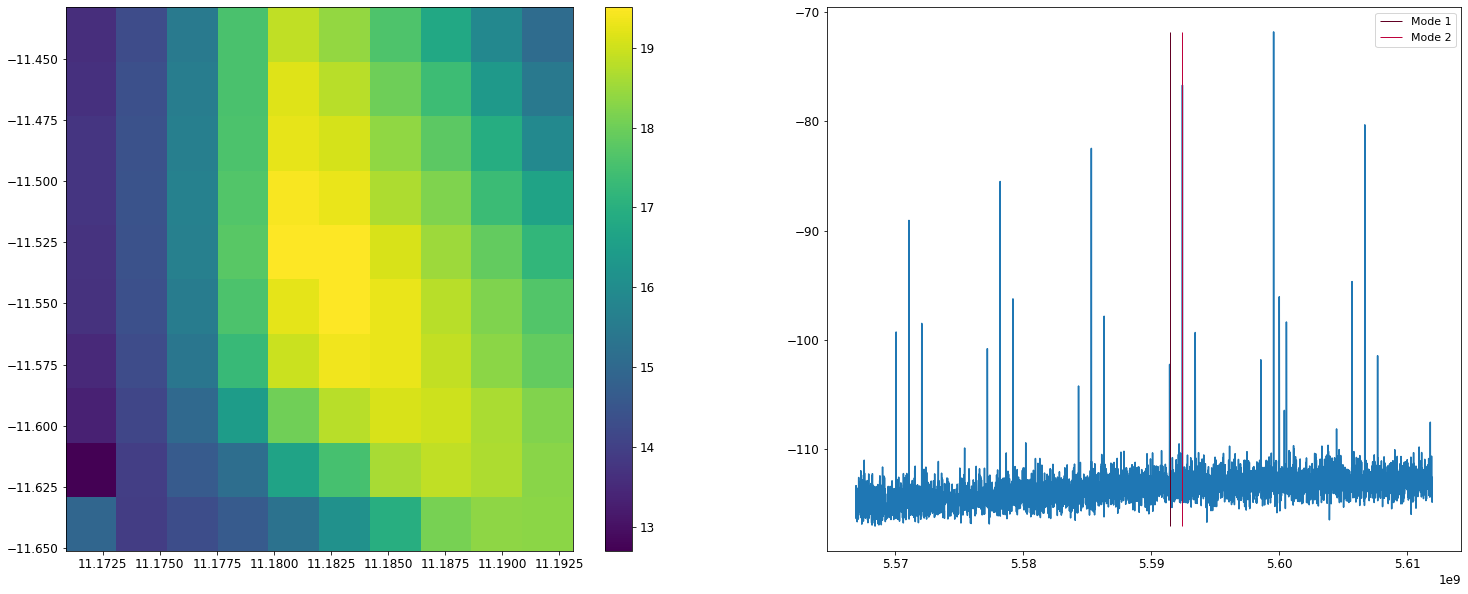

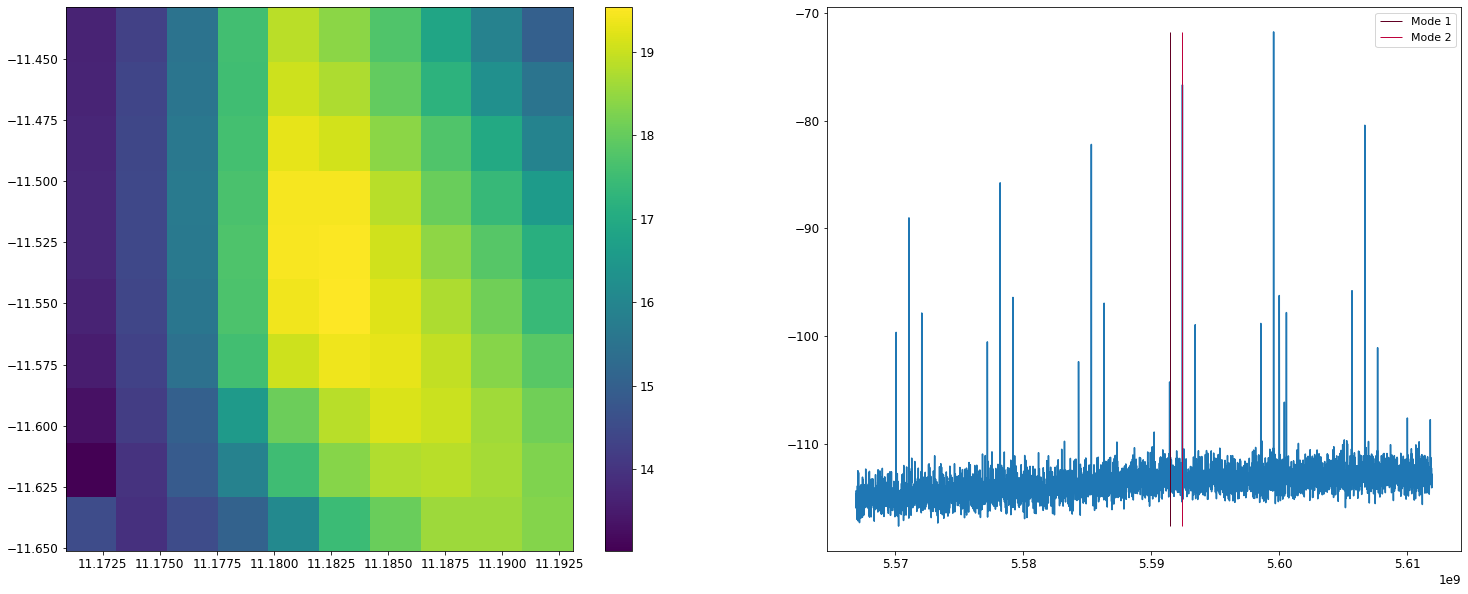

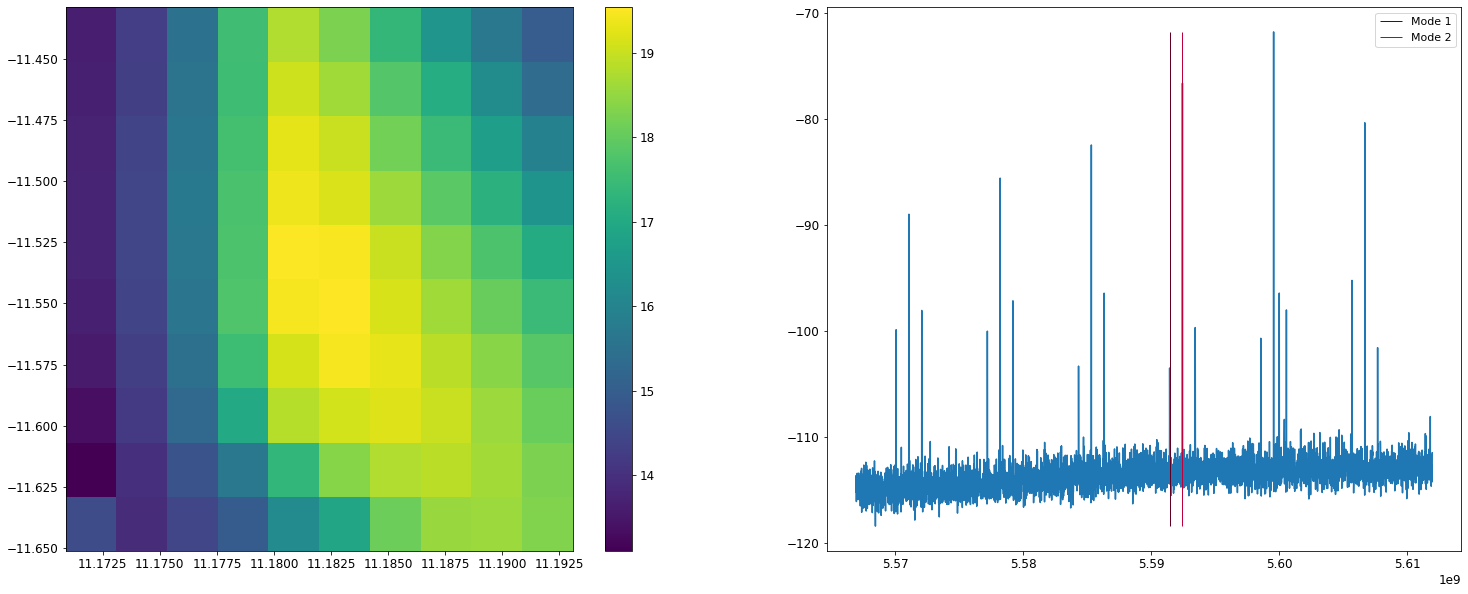

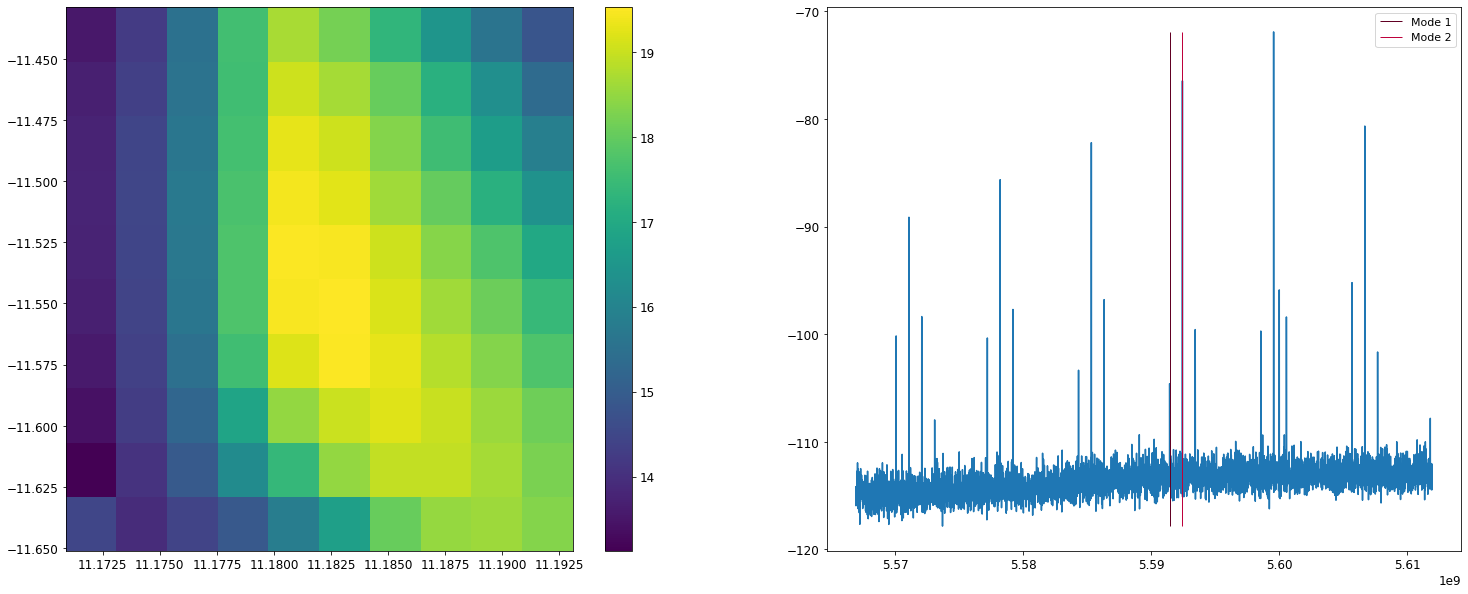

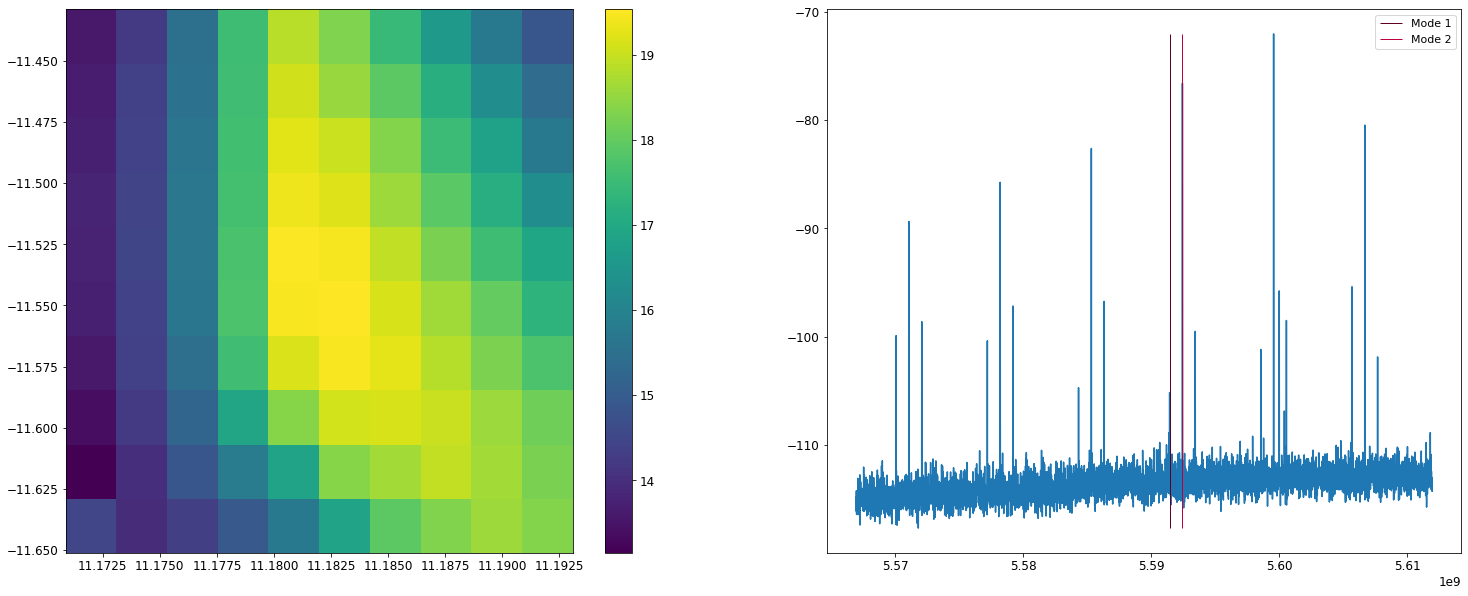

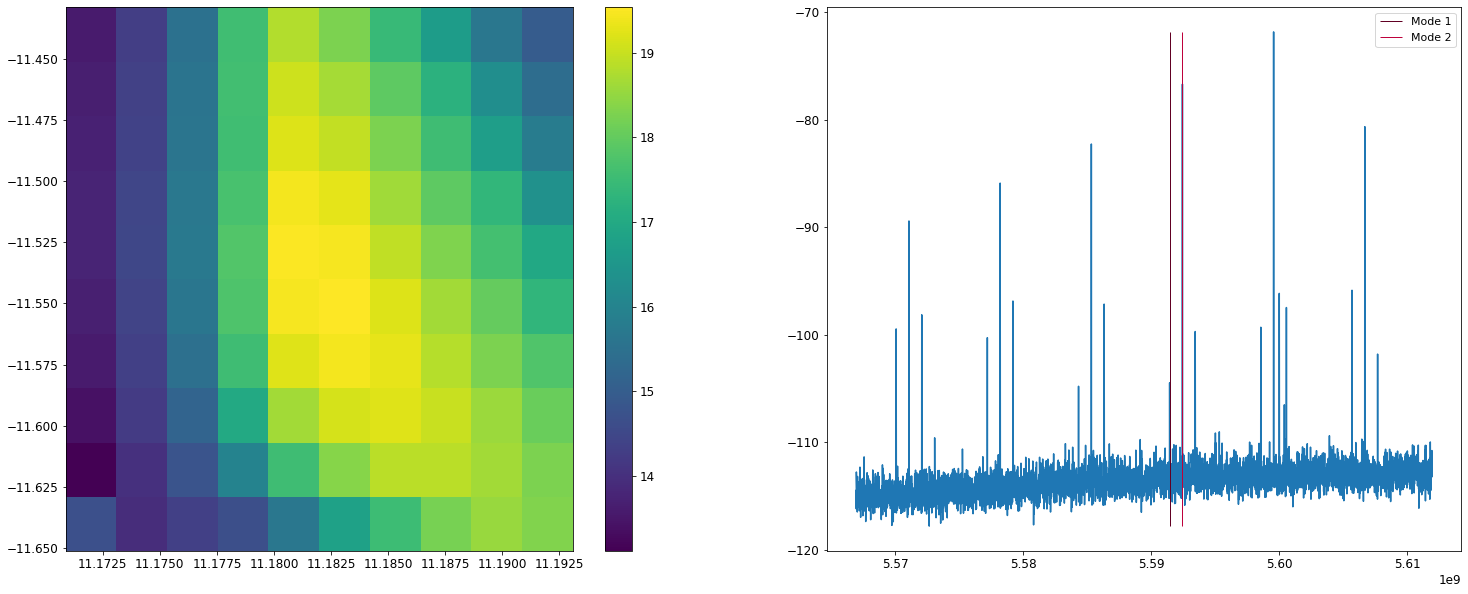

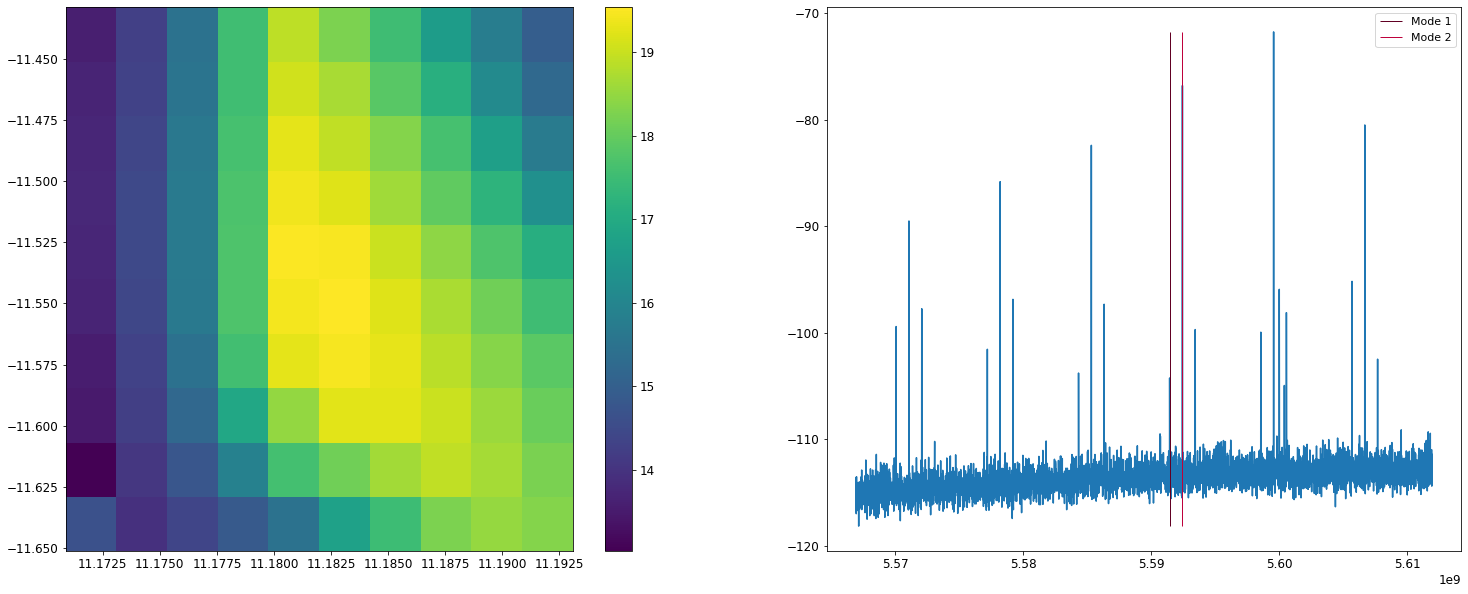

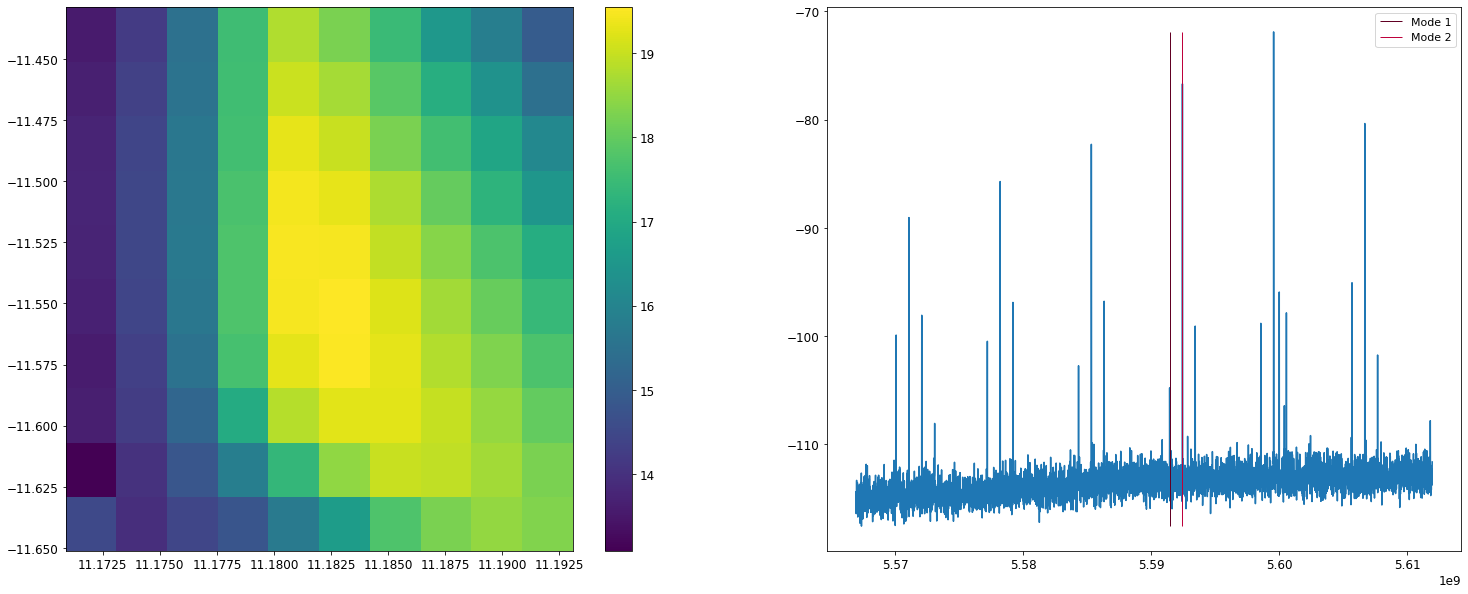

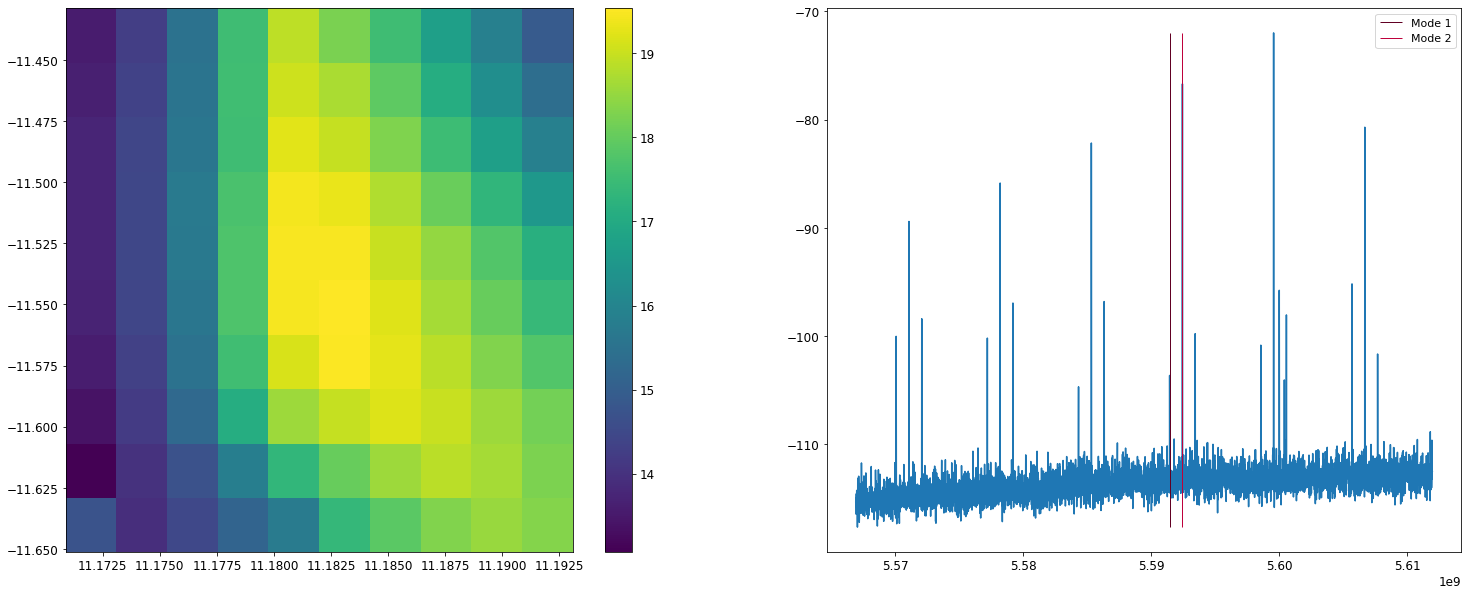

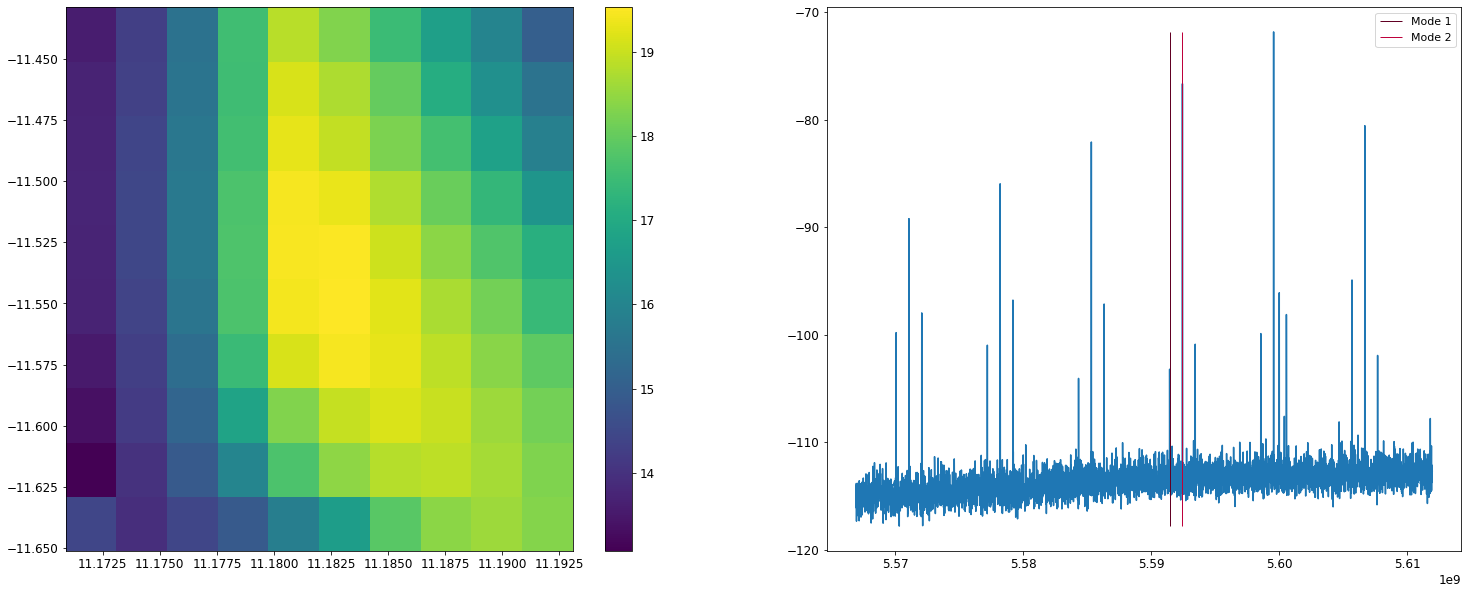

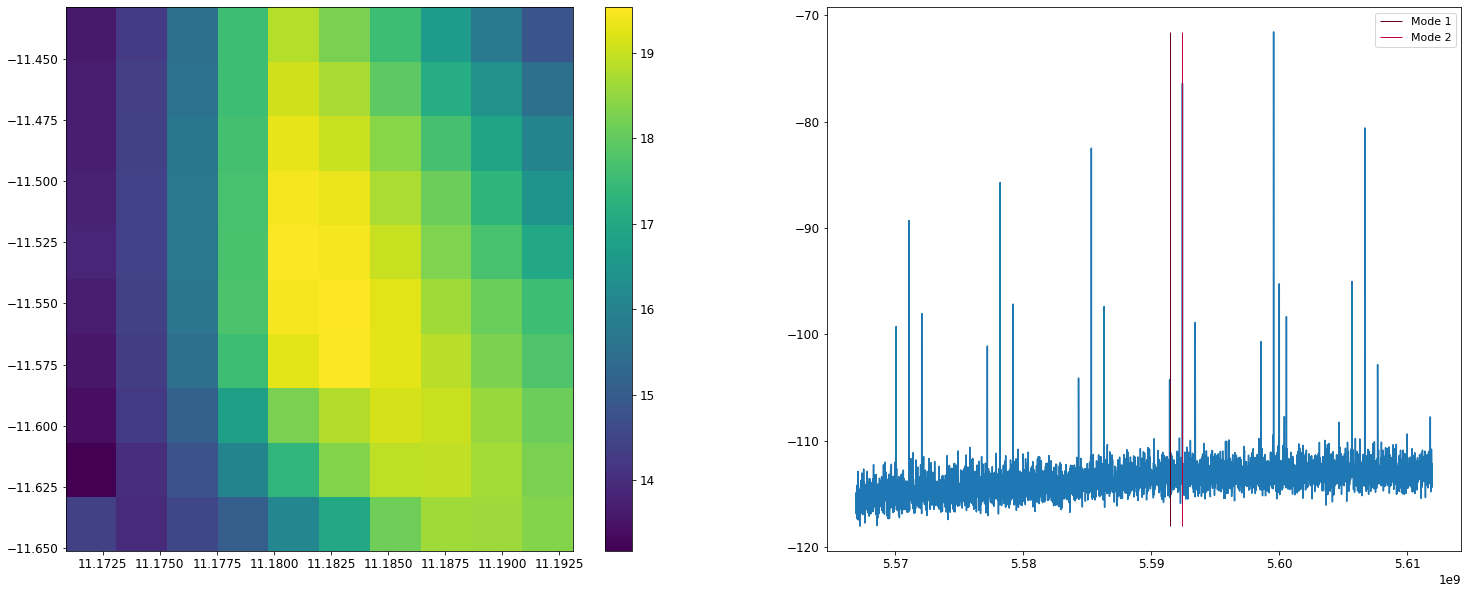

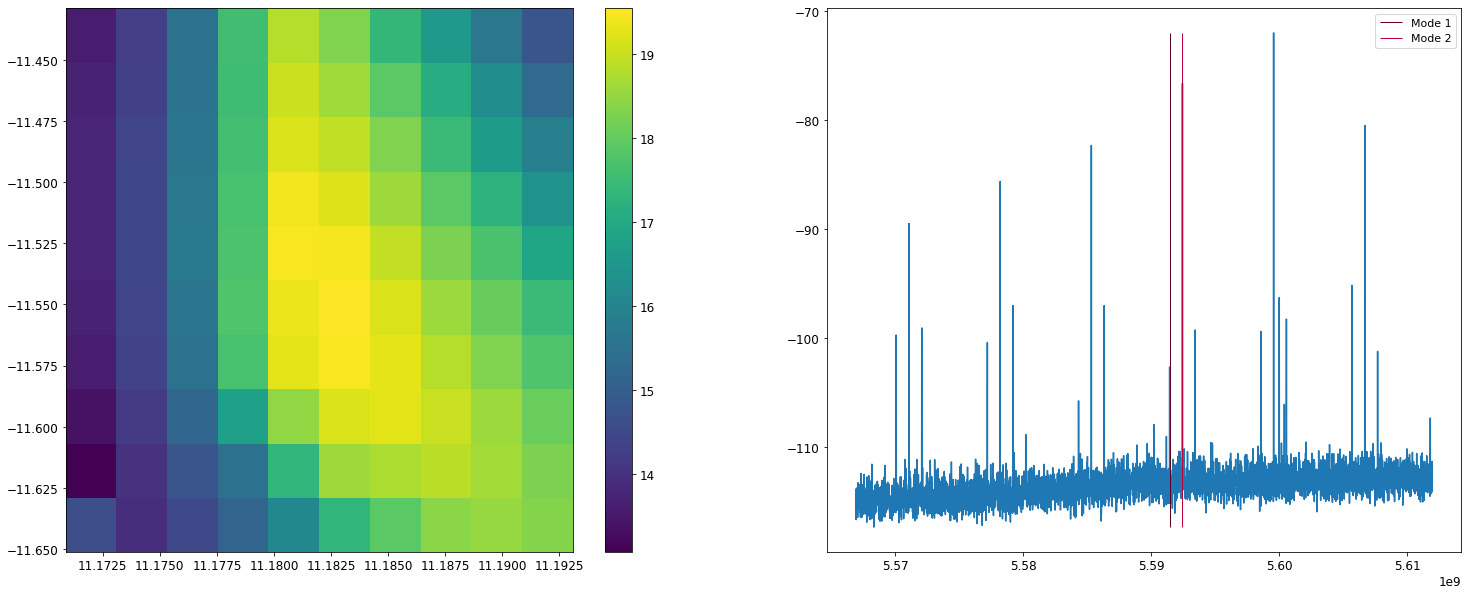

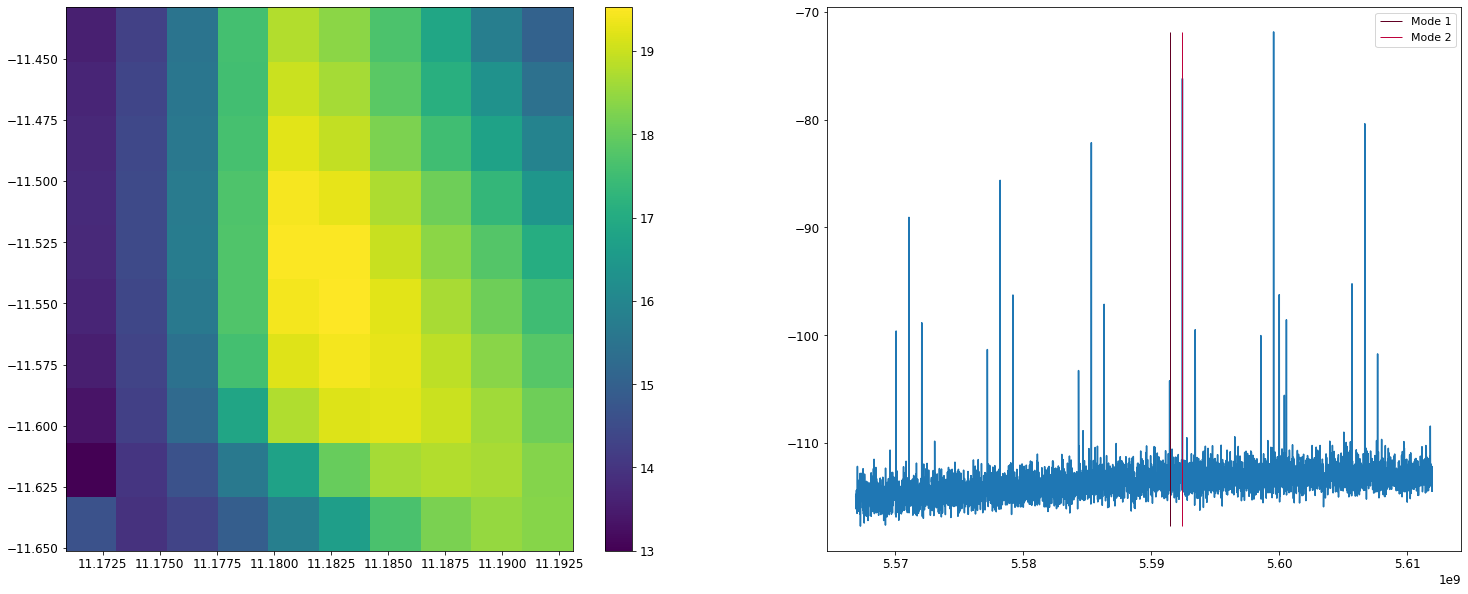

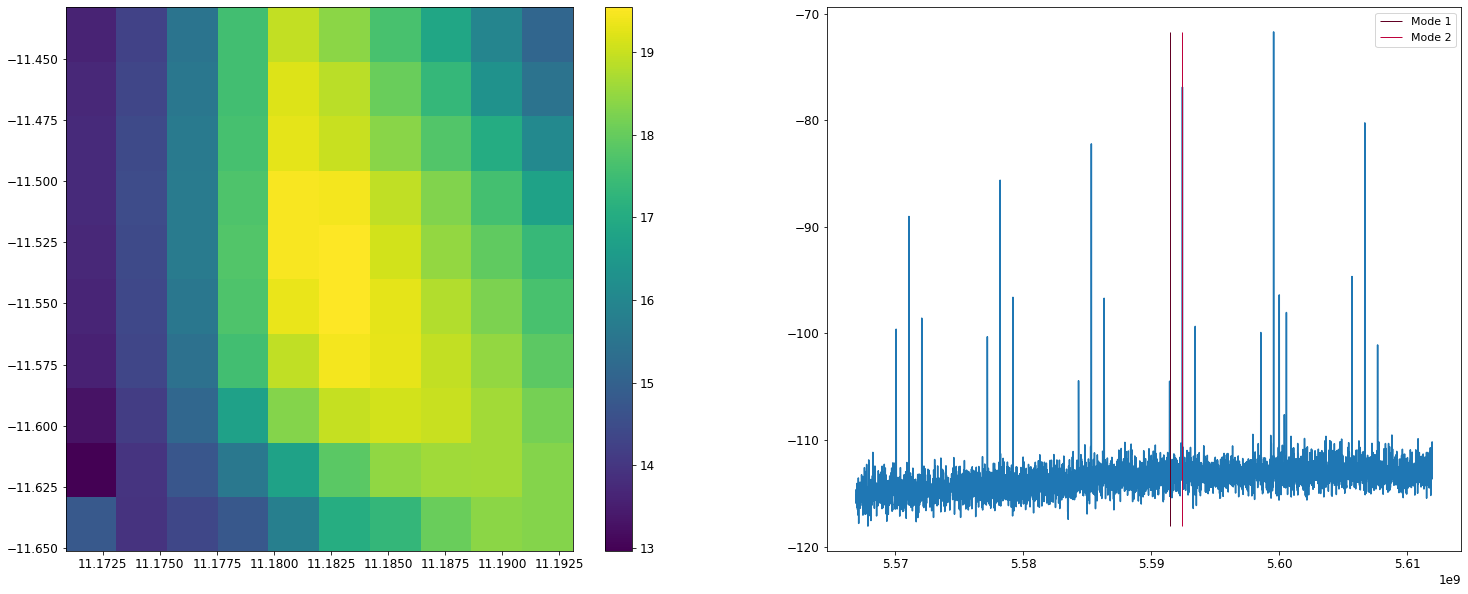

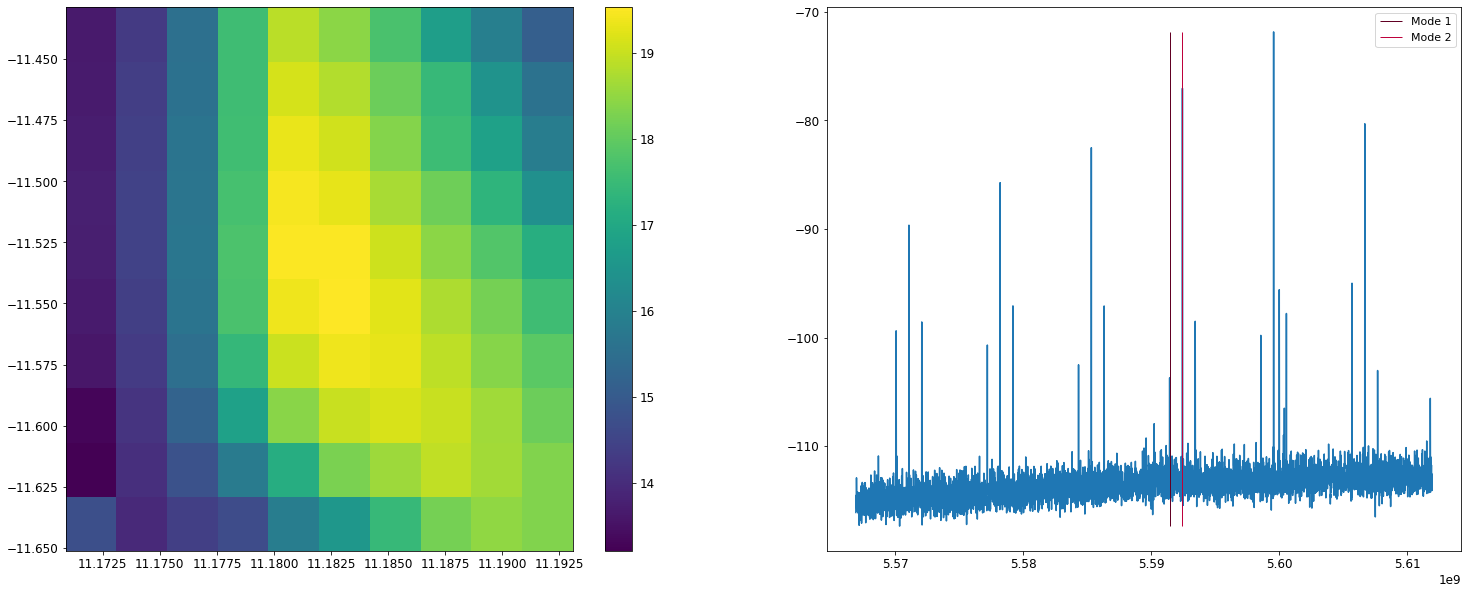

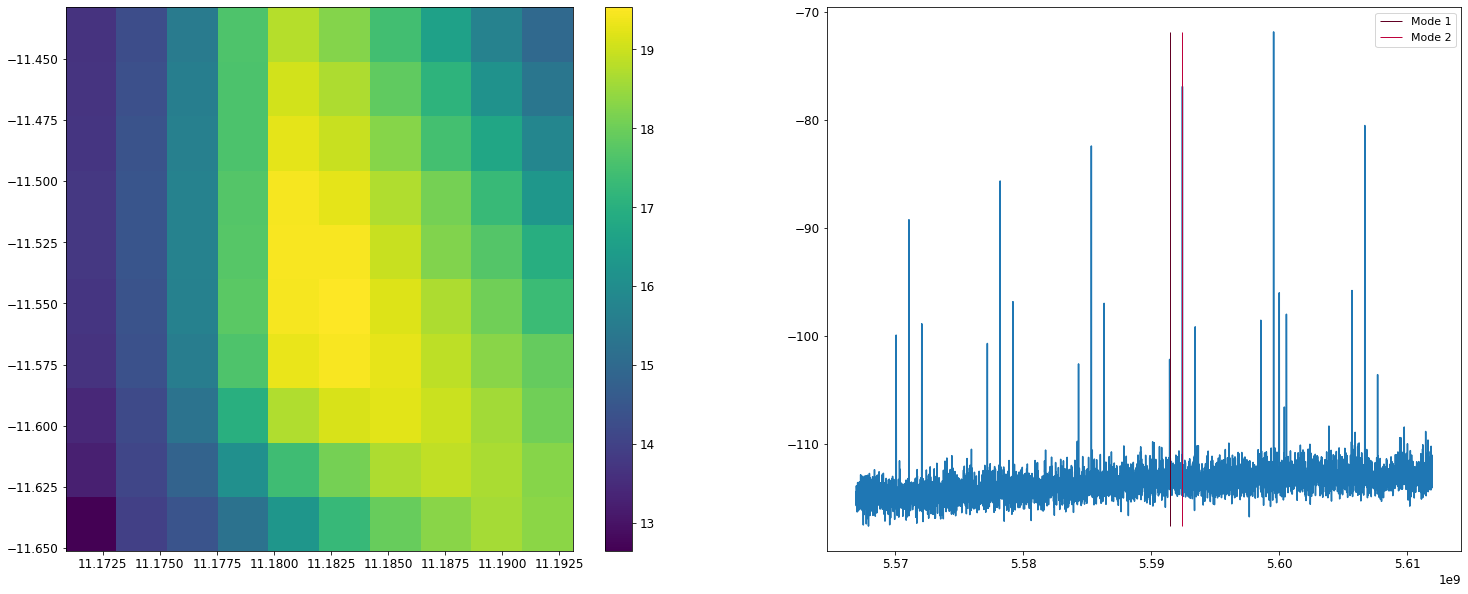

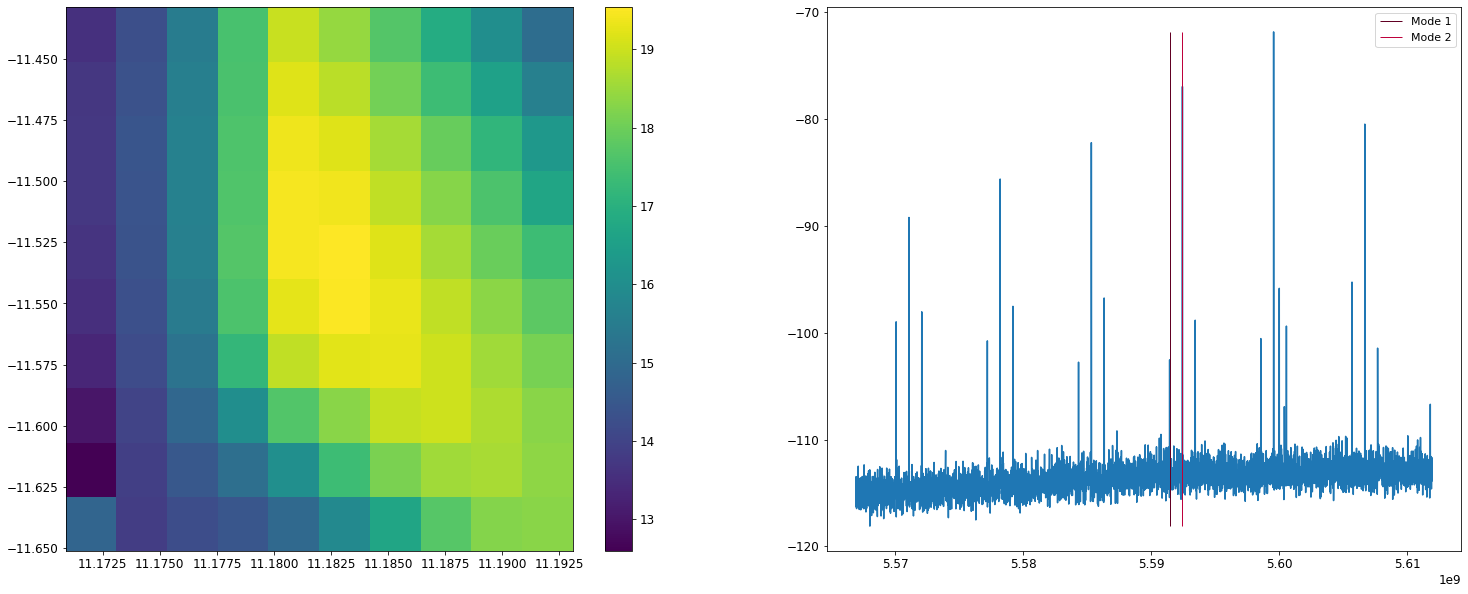

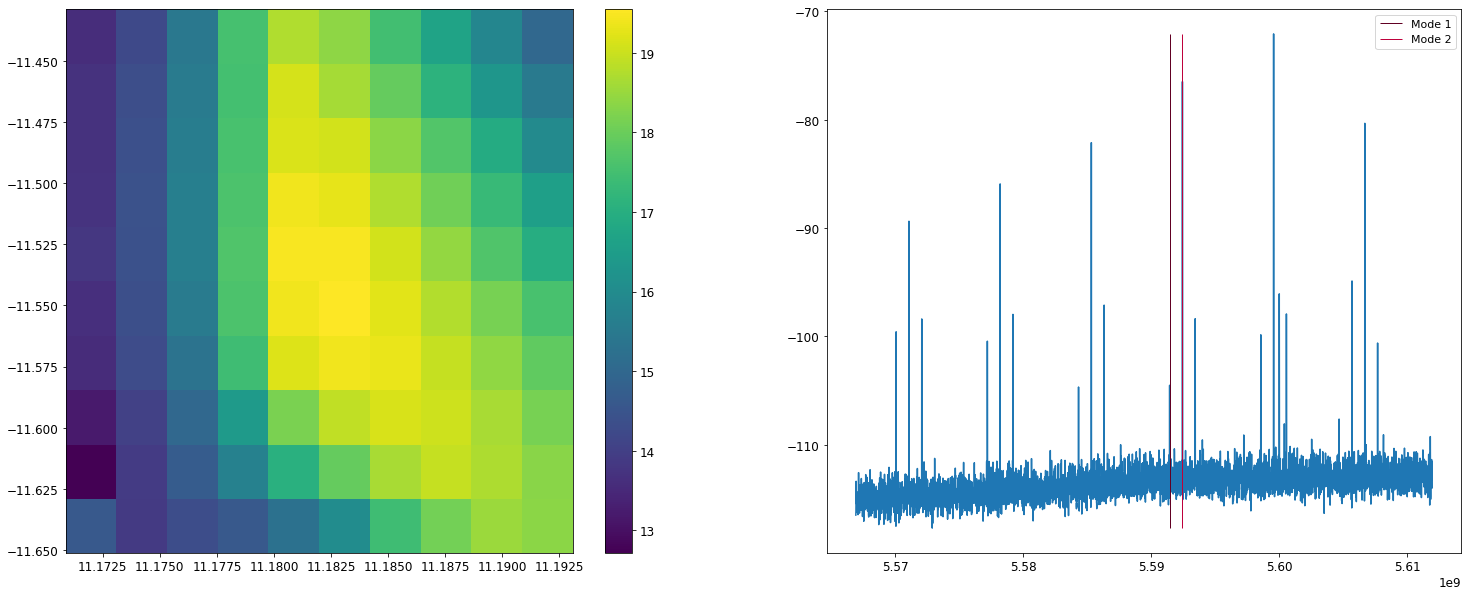

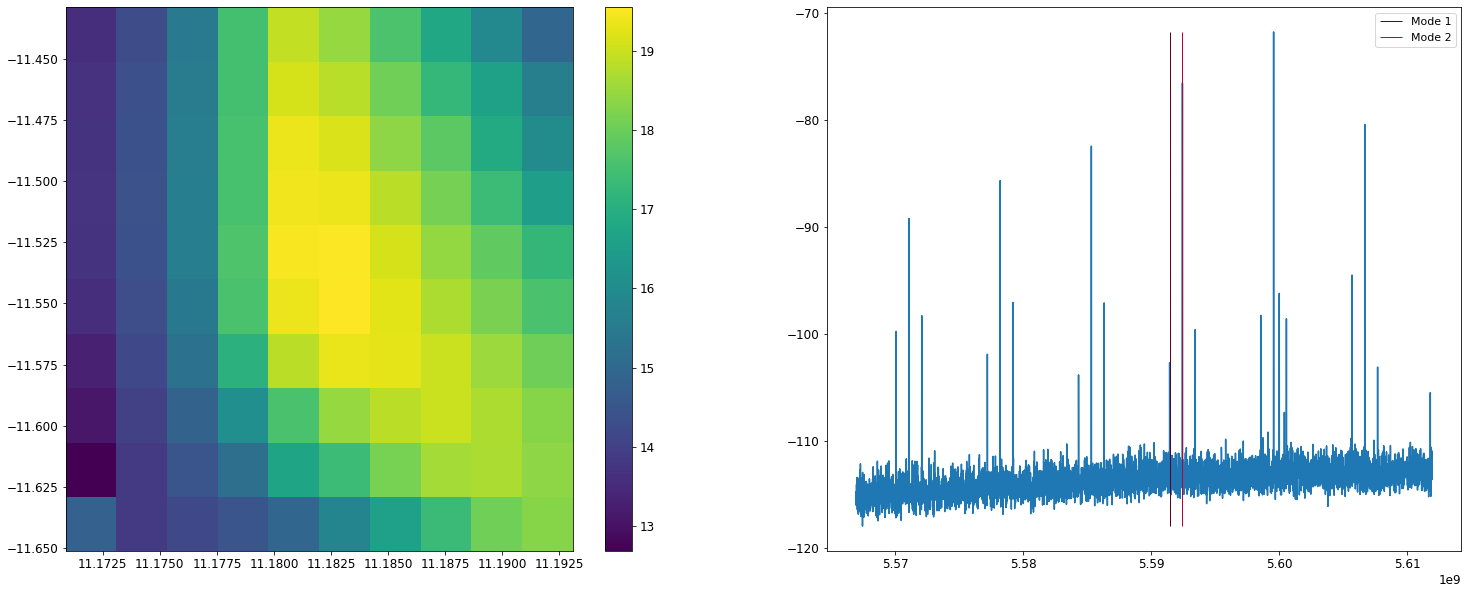

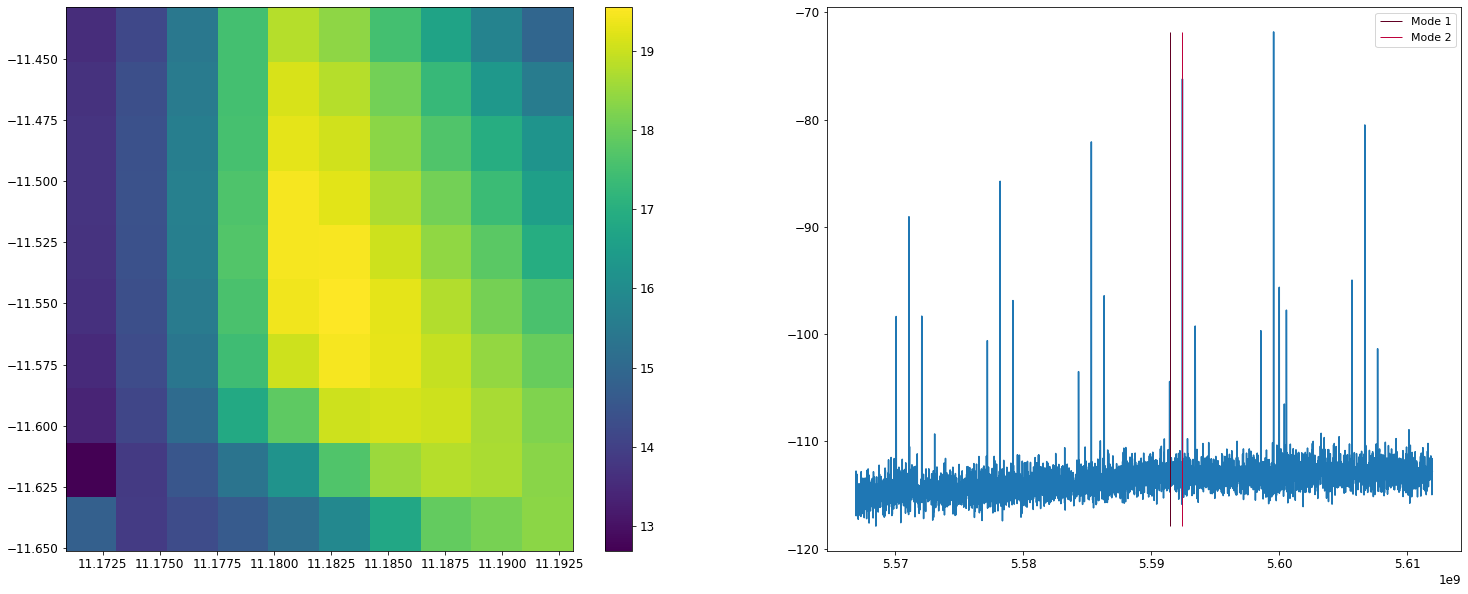

In [187]:
now1 = datetime.now()
print('Start: {}'.format(now1.strftime(r'%H-%M-%S')))

cent_freq = freq_best/2*1e9
span = 45e6
nop = 5001
min_freq = cent_freq-span/2
max_freq = cent_freq+span/2
freq = np.linspace(min_freq, max_freq, nop)
band=100

sa.set_cent_freq(cent_freq)
sa.set_span(span)
sa.set_band_Hz(band)
sa.set_nop(nop)

# TWPA
flux_freq = freq_best*1e9
flux_power = pow_best
anapico.set_freq(1, flux_freq)
anapico.set_power(1, flux_power)
anapico.on(1)

# Modes
mode1 = (freq_best/2+0.002)*1e9
mode1_pow = 0
anapico.set_freq(2, mode1)
anapico.set_power(2, mode1_pow)
anapico.on(2)

mode2 = (freq_best/2+0.003)*1e9
mode2_pow = 0
anapico.set_freq(4, mode2)
anapico.set_power(4, mode2_pow)
anapico.on(4)


volts = np.linspace(2.35,2.55,26)

TWPA_data=dict()
TWPA_data['cent_freq'] = cent_freq
TWPA_data['span'] = span
TWPA_data['nop'] = nop
TWPA_data['freq'] = freq
TWPA_data['band'] = band
TWPA_data['flux_freq'] = flux_freq

TWPA_data['flux_power'] = flux_power
TWPA_data['mode1'] = mode1
TWPA_data['mode1_pow'] = mode1_pow
TWPA_data['mode2'] = mode2
TWPA_data['mode2_pow'] = mode2_pow
TWPA_data['flux_freq'] = flux_freq

TWPA_data['volts'] = volts

spectrum = np.empty((nop, len(volts)))

print('est runtime {}'.format(str(timedelta(seconds=2*60*len(volts)))))

cent_freq = 11.182
cent_pow = -11.54
offset_f = 0.01
offset_p = 0.1

pow_steps = 10
freq_steps = 10
gain = np.empty((len(volts), pow_steps,freq_steps))

for i in range(len(volts)):
    dc.set_volt(volts[i])
#     time.sleep(1)
    now_curr = datetime.now()
    future_date = now_curr + timedelta(seconds=2*60*len(volts[i:]))
    print('New voltage {} set at {}. Finish: {}'.format(volts[i], now_curr.strftime(r'%H:%M.%S'), 
                                                                     future_date.strftime(r'%H:%M.%S')))
    
    fig, ax = plt.subplots(1,2,figsize=(25,10))
    anapico.off(2)
    anapico.off(4)
    

    low_freq = cent_freq-offset_f
    high_freq = cent_freq+offset_f
    low_power = cent_pow-offset_p
    high_power = cent_pow+offset_p
    power_VNA, freq_VNA, gain_VNA = get_FP_sweep(dc_curr=2.40, freq_steps=freq_steps, pow_steps=pow_steps) 
    gain[i] = gain_VNA
    TWPA_data['gain'] = gain
    TWPA_data['freq_VNA'] = freq_VNA
    TWPA_data['power_VNA'] = power_VNA
    c = ax[0].pcolor(freq_VNA, power_VNA, gain_VNA, cmap='viridis')
    fig.colorbar(c, ax= ax[0])


    anapico.on(2)
    anapico.on(4)
    data = sa.get_data()
    spectrum[:,i] = data
    TWPA_data['spectrum'] = spectrum
    
    path = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi\Open_loop\TWPA'
    experiment_name = 'InterProd_{}-{}-{}_TEST'.format(flux_power, mode1_pow, mode2_pow)
    file_name = path+'\\'+experiment_name+now1.strftime(r'%H-%M-%S')+'.mat'
    savemat(file_name, TWPA_data)
    
    
    ax[1].plot(freq, data)
    ax[1].vlines(mode1, min(data), max(data), '#610023', linewidth=1.0, label = 'Mode 1')
    ax[1].vlines(mode2, min(data), max(data), '#be013c', linewidth=1.0,  label = 'Mode 2')
    ax[1].legend(loc = 1, prop={'size': 11})
    path_to_pic = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi\Open_loop\TWPA\pictures'
    pic_name = path_to_pic+'\\'+now1.strftime(r'%H-%M-%S')+'{}_data.png'.format(np.round(volts[i],5))
    plt.savefig(pic_name, facecolor='w', edgecolor='w', bbox_inches='tight')

In [65]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_mode(i, j, k, mp, m1, m2):
    return i*mp+j*m1+k*m2

mp = flux_freq/2/1e9
m1 = mode1/1e9
m2 = mode2/1e9

range_i = np.array([0, 1, -1, 2, -2, 3, -3, 4, -4])

modes_fr_all = np.array([])
modes_fr_1ph = np.array([])
modes_fr_2ph = np.array([])
modes_fr_3ph = np.array([])
modes_fr_4ph = np.array([])
modes_fr_5ph = np.array([])
modes_fr_6ph = np.array([])
modes_fr_7ph = np.array([])
for i in range_i:
    for j in range_i:
        for k in range_i:
            mode = np.round(get_mode(i, j, k, mp, m1, m2),3)
            if mode<max(freq/1e9) and mode>min(freq/1e9):
                modes_fr_all = np.append(modes_fr_all, mode)

                if int(abs(i)+abs(j)+abs(k))==1: modes_fr_1ph = np.append(modes_fr_1ph, mode)

                if int(abs(i)+abs(j)+abs(k))==2: 
                    modes_fr_2ph = np.append(modes_fr_2ph, mode)

                if int(abs(i)+abs(j)+abs(k))==3: 
                    modes_fr_3ph = np.append(modes_fr_3ph, mode)

                if int(abs(i)+abs(j)+abs(k))==4: 
                    modes_fr_4ph = np.append(modes_fr_4ph, mode)

                if int(abs(i)+abs(j)+abs(k))==5: 
                    modes_fr_5ph = np.append(modes_fr_5ph, mode)

                if int(abs(i)+abs(j)+abs(k))==6: 
                    modes_fr_6ph = np.append(modes_fr_6ph, mode)

                if int(abs(i)+abs(j)+abs(k))==7: 
                    modes_fr_7ph = np.append(modes_fr_7ph, mode)

modes_fr_1ph_sort = np.unique(np.sort(np.round(modes_fr_1ph,3)))
modes_fr_2ph_sort = np.unique(np.sort(np.round(modes_fr_2ph,3)))
modes_fr_3ph_sort = np.unique(np.sort(np.round(modes_fr_3ph,3)))
modes_fr_4ph_sort = np.unique(np.sort(np.round(modes_fr_4ph,3)))
modes_fr_5ph_sort = np.unique(np.sort(np.round(modes_fr_5ph,3)))
modes_fr_6ph_sort = np.unique(np.sort(np.round(modes_fr_6ph,3)))
modes_fr_7ph_sort = np.unique(np.sort(np.round(modes_fr_7ph,3)))

modes_fr_all_sort = np.unique(np.sort(np.round(modes_fr_all,3)))

ind_3 = np.array([], dtype=int)
for i in range(len(modes_fr_3ph_sort)):
    if np.any(modes_fr_1ph_sort == modes_fr_3ph_sort[i]):
        ind_3 = np.append(ind_3, i)

modes_fr_3ph_sort = np.delete(modes_fr_3ph_sort, ind_3)

ind_5 = np.array([], dtype=int)
for i in range(len(modes_fr_5ph_sort)):
    if np.any(modes_fr_1ph_sort == modes_fr_5ph_sort[i]) or np.any(modes_fr_3ph_sort == modes_fr_5ph_sort[i]):
        ind_5 = np.append(ind_5, i)

modes_fr_5ph_sort = np.delete(modes_fr_5ph_sort, ind_5)

ind_7 = np.array([], dtype=int)
for i in range(len(modes_fr_7ph_sort)):
    if np.any(modes_fr_1ph_sort == modes_fr_7ph_sort[i]) or np.any(modes_fr_3ph_sort == modes_fr_7ph_sort[i]) or np.any(modes_fr_5ph_sort == modes_fr_7ph_sort[i]):
        ind_7 = np.append(ind_7, i)

modes_fr_7ph_sort = np.delete(modes_fr_7ph_sort, ind_7)

In [185]:
volts

array([2.35 , 2.354, 2.358, 2.362, 2.366, 2.37 , 2.374, 2.378, 2.382,
       2.386, 2.39 , 2.394, 2.398, 2.402, 2.406, 2.41 , 2.414, 2.418,
       2.422, 2.426, 2.43 , 2.434, 2.438, 2.442, 2.446, 2.45 , 2.454,
       2.458, 2.462, 2.466, 2.47 , 2.474, 2.478, 2.482, 2.486, 2.49 ,
       2.494, 2.498, 2.502, 2.506, 2.51 , 2.514, 2.518, 2.522, 2.526,
       2.53 , 2.534, 2.538, 2.542, 2.546, 2.55 ])

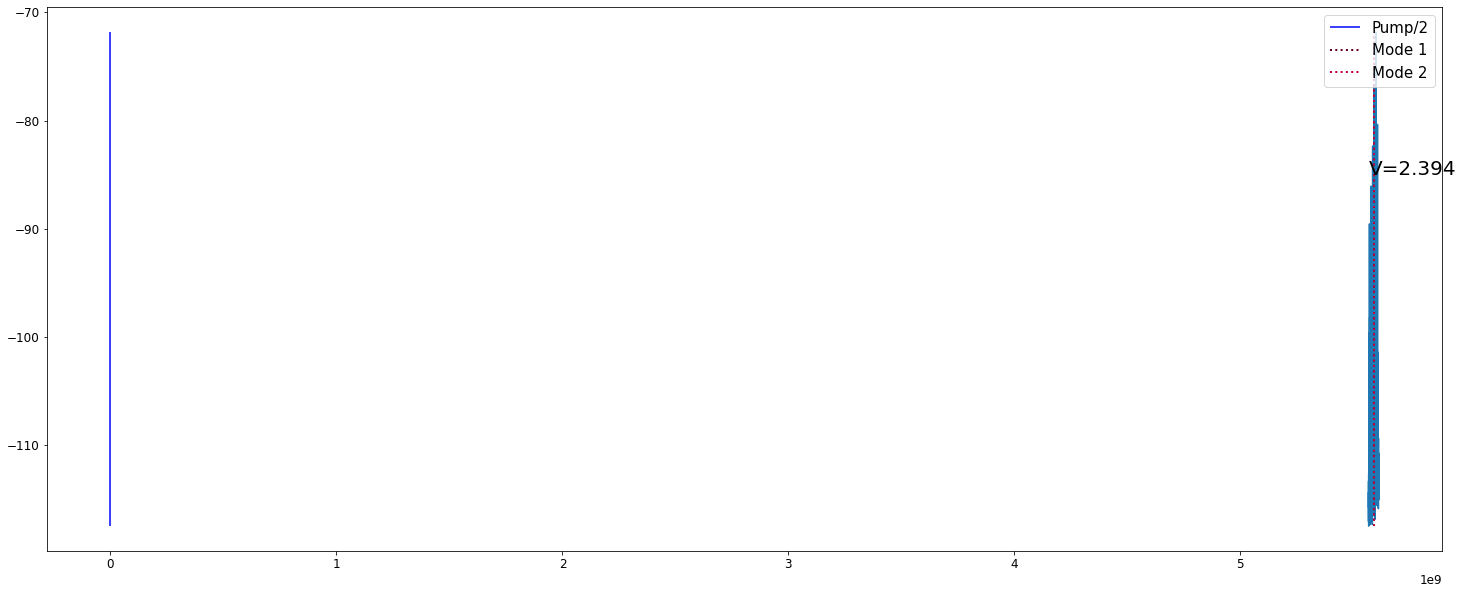

In [186]:
fig, ax = plt.subplots(figsize=(25,10))
dat = spectrum[:,11]
ax.plot(freq, dat)
ax.vlines(cent_freq, min(dat), max(dat), 'blue',  label = 'Pump/2')
ax.vlines(mode1, min(dat), max(dat), '#610023', linewidth=2.0, linestyle = ':', label = 'Mode 1')
ax.vlines(mode2, min(dat), max(dat), '#be013c', linewidth=2.0, linestyle = ':', label = 'Mode 2')

# ax.vlines(mode2-mode1+cent_freq, min(dat), max(dat), 'green', linewidth=1.0, linestyle = ':', label = 'Mode 2')

# for i in range(len(modes_fr_5ph_sort)): 
#     ax.vlines(modes_fr_5ph_sort[i]*1e9, min(dat), max(dat),  linewidth=2.0, linestyle = ':', label = 'Mode 1ph{}'.format(i))

ax.legend(loc = 1, prop={'size': 15})

ax.text(min(freq), -85, 'V={}'.format(np.round(volts[11],5)), size=20)


path_to_pic = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\CoSi\Open_loop\TWPA\pictures'
pic_name = path_to_pic+'\\'+'data_best.png'
plt.savefig(pic_name, facecolor='w', edgecolor='w', bbox_inches='tight')

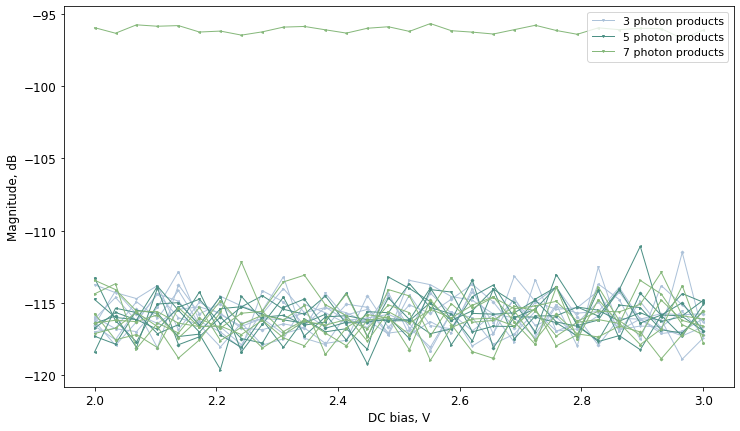

In [36]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(12,7))
ax.set_xlabel('DC bias, V')
ax.set_ylabel('Magnitude, dB')


treshhold = 0
cmap = plt.get_cmap('Purples_r')
x = np.linspace(0, 1, int(len(modes_fr_1ph_sort)+2))
colors = cmap(x)
control_color = -1
marker_list = [ ">", "D", "o", "v", "<", "p","2"]
ml=-1
for im, m in enumerate(modes_fr_1ph_sort):
    control_color += 1
    mag = np.array([])
    power = np.array([])
    for i in range(len(volts)):
        volt = volts[i]
        freq_sweep = freq
        data = spectrum[:,i]
        
        mode_index = find_nearest(freq/1e9, m)
        mag_max = max(data[mode_index-20:mode_index+20])
        mag = np.append(mag, data[mode_index])
        power = np.append(power, volt)
    if max(mag)-min(mag)>treshhold:
        ml +=1
        if np.round(m,3)==flux_freq/1e9/2:
            ax.plot(power, mag, marker = marker_list[mod(ml,5)], color = colors[control_color], 
                    linestyle='-.', markersize=2, linewidth=1.5, label = '$\omega_{p}/2$', zorder=10)
            
        if np.round(m,3)==mode1/1e9:
            ax.plot(power, mag, marker = marker_list[mod(ml,5)], color = colors[control_color], 
                    linestyle='dotted', markersize=2, linewidth=1.5, label = '$\omega_{1}$', zorder=10)
            
        if np.round(m,3)==mode2/1e9:
            ax.plot(power, mag, marker = marker_list[mod(ml,5)], color = colors[control_color], 
                    linestyle='--', markersize=2, linewidth=1.5, label = '$\omega_{2}$', zorder=10)


colors = cmap(x)
control_color = -1
marker_list = [ ">", "D", "o", "v", "<", "p","2"]
ml=-1
for im, m in enumerate(modes_fr_3ph_sort):
    control_color += 1
    mag = np.array([])
    power = np.array([])
    for i in range(len(volts)):
        volt = volts[i]
        freq_sweep = freq
        data = spectrum[:,i]
        
        mode_index = find_nearest(freq_sweep/1e9, m)
        mag_max = max(data[mode_index-10:mode_index+10])
        mag = np.append(mag, data[mode_index])
        power = np.append(power, volt)
    if max(mag)-min(mag)>treshhold:
        ml +=1
        if im == 3:
            ax.plot(power, mag, marker = marker_list[mod(ml,5)], markersize=2,
                color = '#acc2d9', linewidth=1, label = '3 photon products', zorder=3)
        else: ax.plot(power, mag, marker = marker_list[mod(ml,5)], markersize=2,
                color = '#acc2d9', linewidth=1, zorder=3)


cmap = plt.get_cmap('YlOrBr_r')
x = np.linspace(0, 1, int(len(modes_fr_5ph_sort)+5))
colors = cmap(x)
control_color = -1
marker_list = [ ">", "D", "o", "v", "<", "p","2"]
ml=-1
for im, m in enumerate(modes_fr_5ph_sort):
    control_color += 1
    mag = np.array([])
    power = np.array([])
    for i in range(len(volts)):
        volt = volts[i]
        freq_sweep = freq
        data = spectrum[:,i]
        
        mode_index = find_nearest(freq_sweep/1e9, m)
        mag_max = max(data[mode_index-10:mode_index+10])
        mag = np.append(mag, data[mode_index])
        power = np.append(power, volt)
    if max(mag)-min(mag)>treshhold:
        ml +=1
        if im==3:
            ax.plot(power, mag, marker = marker_list[mod(ml,5)], markersize=2,
                    color = '#4c9085', linewidth=1, label = '5 photon products', zorder=3)
        else: ax.plot(power, mag, marker = marker_list[mod(ml,5)], markersize=2,
                    color = '#4c9085', linewidth=1, zorder=3)

        
cmap = plt.get_cmap('Blues_r')
x = np.linspace(0, 1, int(len(modes_fr_7ph_sort)+5))
colors = cmap(x)
control_color = -1
marker_list = [ ">", "D", "o", "v", "<", "p","2"]
ml=-1
for im, m in enumerate(modes_fr_7ph_sort):
    control_color += 1
    mag = np.array([])
    power = np.array([])
    for i in range(len(volts)):
        volt = volts[i]
        freq_sweep = freq
        data = spectrum[:,i]
        
        mode_index = find_nearest(freq_sweep/1e9, m)
        mag_max = max(data[mode_index-10:mode_index+10])
        mag = np.append(mag, data[mode_index])
        power = np.append(power, volt)
    if max(mag)-min(mag)>treshhold:
        ml +=1
        if im ==3: 
            ax.plot(power, mag, marker = marker_list[mod(ml,5)], markersize=2,
                color = '#86b87b', linewidth=1, label = '7 photon products', zorder=3)
        else: 
            ax.plot(power, mag, marker = marker_list[mod(ml,5)], markersize=2,
                color = '#86b87b', linewidth=1, zorder=3)
    
# ax.vlines(2.5, 0, -105, '#610023', linewidth=1.0, label = 'Large intermodulation\n products regime', zorder=99)
# ax.vlines(2.25, 0, -105, '#be013c',linewidth=1.0,  label = 'Small intermodulation\n products regime', zorder=99)
# ax.set_ylim(-105, 0)
        
ax.legend(loc = 1, prop={'size': 11}).set_zorder(101)

In [181]:
volts

array([2.35      , 2.35408163, 2.35816327, 2.3622449 , 2.36632653,
       2.37040816, 2.3744898 , 2.37857143, 2.38265306, 2.38673469,
       2.39081633, 2.39489796, 2.39897959, 2.40306122, 2.40714286,
       2.41122449, 2.41530612, 2.41938776, 2.42346939, 2.42755102,
       2.43163265, 2.43571429, 2.43979592, 2.44387755, 2.44795918,
       2.45204082, 2.45612245, 2.46020408, 2.46428571, 2.46836735,
       2.47244898, 2.47653061, 2.48061224, 2.48469388, 2.48877551,
       2.49285714, 2.49693878, 2.50102041, 2.50510204, 2.50918367,
       2.51326531, 2.51734694, 2.52142857, 2.5255102 , 2.52959184,
       2.53367347, 2.5377551 , 2.54183673, 2.54591837, 2.55      ])